## **DS207, Time Series Forecasting, Group Project**

**Students:** *M.Davtyan, L.Galstyan, A.Baghdasaryan*

**Instructor:** *Aram Butavyan*

# AUA CSE, SPRING 2023

### Source of the data 
* The data comes from http://www.sidc.be/
* A full description can be found here http://www.sidc.be/silso/infosndtot

**The data gather the daily total sunspot number from 1818.**

### Description of the data 
Columns are :
* Year
* Month
* Day
* Fraction of the year
* Total sunspot number
* Standard deviation
* Number of observations
* Indicator : observation has been done or not.

**(-1) stands for NAN**

Daily total sunspot number derived by the formula: R= Ns + 10 * Ng, with Ns the number of spots and Ng the number of groups counted over the entire solar disk.

**Do univariate analysis for target variable, that is apply two models for estimation and forecasting SARIMA
and Holt Winter’s (exponential smoothing).
The *SARIMA* should include the following steps of modeling:**

• plot the data and comment on existence of seasonality and/or trend2

• transform the data (if necessary), check stationarity (ADF, KPSS, comment)

• identify the dependence orders of the model (ACF, PACF diagnostic, comment)

• Divide the data into train and test sets (take the ratio of your choice) estimate the model on
train set

• perform residual diagnostics (including Ljung-Box test, comment)

• estimate model on train set with auto.arima, do forecast with both models for test set, choose
best model based on minimum Mean Squared Error (if best model is one with auto.arima
comment, e.g. try to understand does it make sense or not)

• Estimate best model for original data (100%), forecast with best model (choose forecast periods
that relevant for your research question), plot the data and forecast.

In [3]:
# Import librairies
%matplotlib inline 
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from timeit import default_timer as timers
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
#!pip install pmdarima
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
#!pip install arch
import arch

In [4]:
# load the data
df = pd.read_csv('/sunspot_data.csv')
del(df['Unnamed: 0'])
#replacing -1 with NAN, indicating no observation for the given date
df['Number of Sunspots'].replace(-1, np.nan, inplace=True)

In [5]:
#head of the data
df.head(10)

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,1818,1,1,1818.001,NaN,-1.0,0,1
1,1818,1,2,1818.004,NaN,-1.0,0,1
2,1818,1,3,1818.007,NaN,-1.0,0,1
3,1818,1,4,1818.010,NaN,-1.0,0,1
4,1818,1,5,1818.012,NaN,-1.0,0,1
5,1818,1,6,1818.015,NaN,-1.0,0,1
6,1818,1,7,1818.018,NaN,-1.0,0,1
7,1818,1,8,1818.021,65.0,10.2,1,1
8,1818,1,9,1818.023,NaN,-1.0,0,1
9,1818,1,10,1818.026,NaN,-1.0,0,1


In [6]:
#shape of the data
df.shape

(73718, 8)

In [7]:
#summary statistics of the data
df.describe()

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
count,73718.000000,73718.000000,73718.000000,73718.000000,70471.000000,73718.000000,73718.000000,73718.000000
mean,1918.416750,6.518896,15.729347,1918.916406,82.946247,6.924587,4.429678,0.998331
std,58.264401,3.447114,8.800032,58.264520,77.252109,4.778793,7.884112,0.040814
min,1818.000000,1.000000,1.000000,1818.001000,0.000000,-1.000000,0.000000,0.000000
25%,1868.000000,4.000000,8.000000,1868.458500,21.000000,3.000000,1.000000,1.000000
50%,1918.000000,7.000000,16.000000,1918.917500,63.000000,6.600000,1.000000,1.000000
75%,1969.000000,10.000000,23.000000,1969.373250,127.000000,10.000000,1.000000,1.000000
max,2019.000000,12.000000,31.000000,2019.832000,528.000000,77.700000,60.000000,1.000000



* Mean: The mean value represents the average value for each attribute. The mean number of sunspots is approximately 82.95.

* Standard Deviation (std): The standard deviation quantifies the dispersion or variability in the data. The standard deviation of the number of sunspots is approximately 77.25.

* 25th Percentile (25%): The 25th percentile indicates the value below which 25% of the observations fall. The 25th percentile for the number of sunspots is 21, suggesting that a significant portion of the dataset contains lower sunspot counts.

* 50th Percentile (50% or median): The 50th percentile represents the middle value of the dataset. The median number of sunspots is 63, indicating that half of the observations have a count below this value.

* 75th Percentile (75%): The 75th percentile indicates the value below which 75% of the observations fall. The 75th percentile for the number of sunspots is 127, suggesting that a significant portion of the dataset contains higher sunspot counts.

In [8]:
#Let's create a whole Date column based on Year, Month, and Day columns.
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

The target variable is the column "Number of Sunspots". In the plot below you can see the distribution of of solar spots over the time (from 1818 to 2019).

<function matplotlib.pyplot.show(close=None, block=None)>

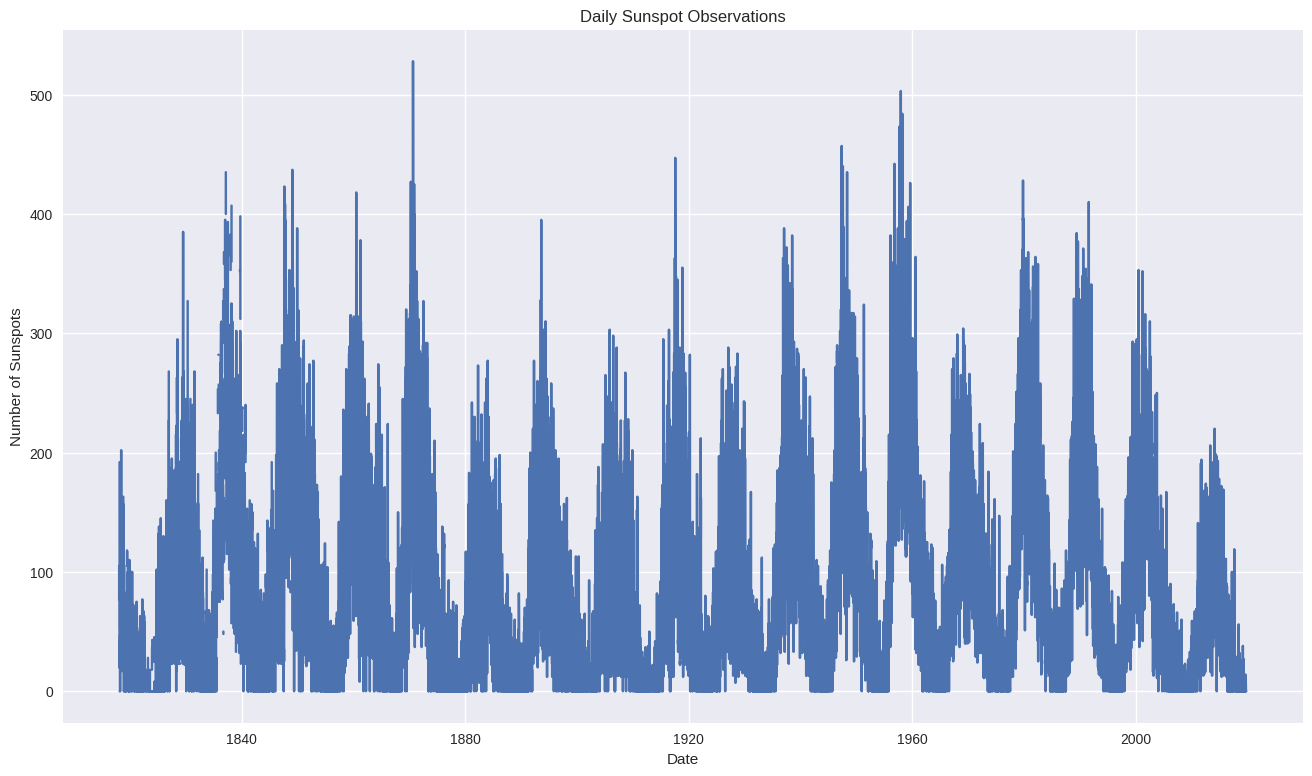

In [9]:
plt.plot(df['Date'], df['Number of Sunspots'])
plt.title('Daily Sunspot Observations')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.show

#### Plot the data and comment on existence of seasonality and/or trend2

***Aggregating the data monthly***

<Axes: xlabel='Date', ylabel='Number of Sunspots'>

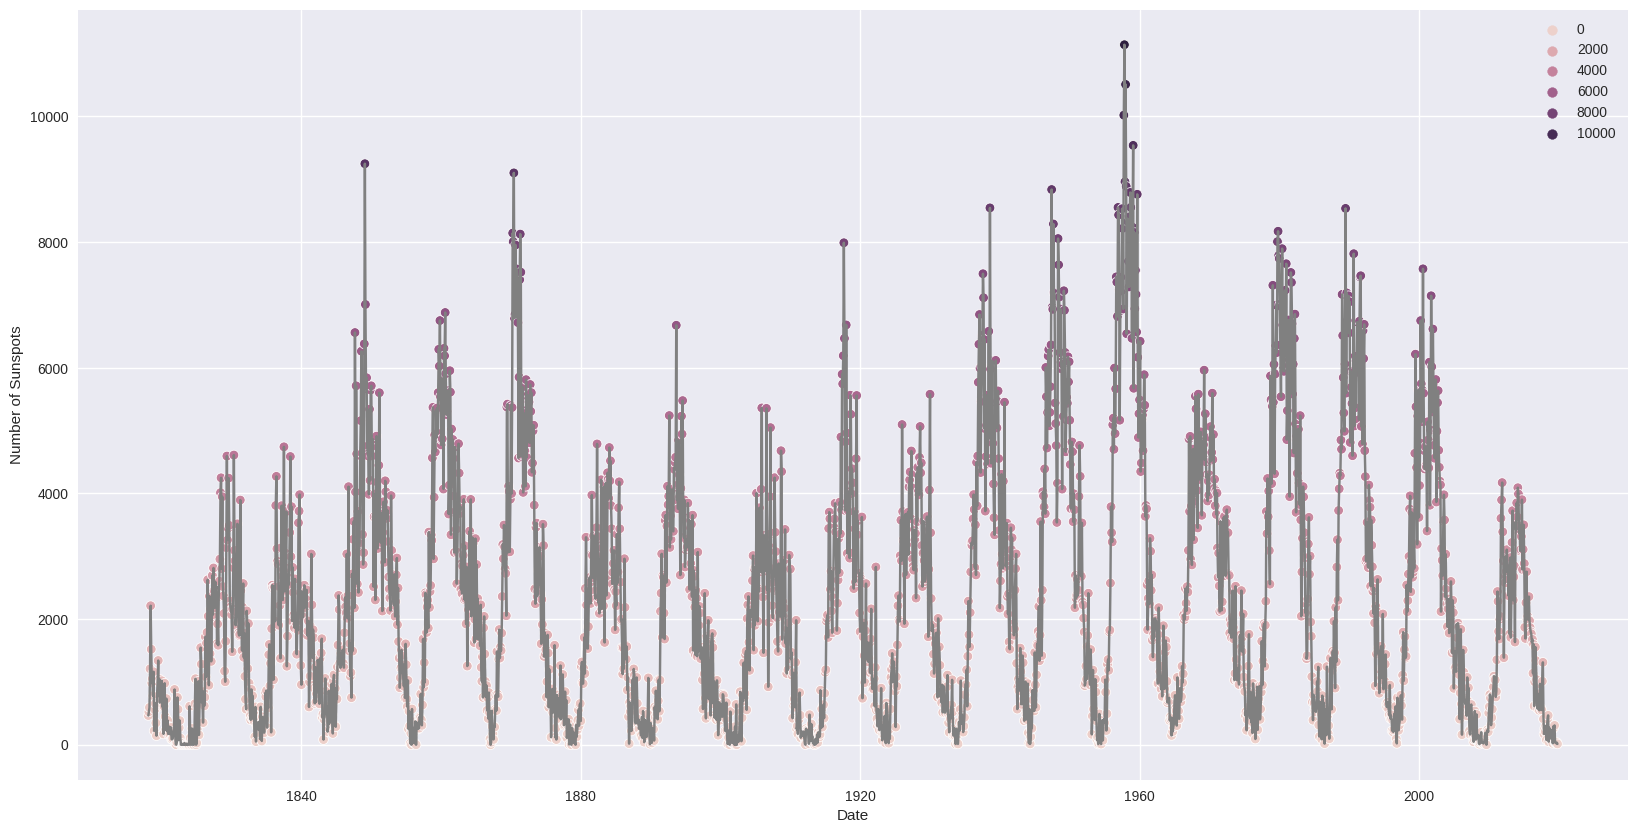

In [10]:
sum_of_sunspots_per_month = df.groupby(pd.Grouper(key='Date', freq='M')).sum()['Number of Sunspots']
months = sum_of_sunspots_per_month.index
plt.figure(figsize=(20,10))
sns.scatterplot(x=months, y=sum_of_sunspots_per_month, hue=sum_of_sunspots_per_month)
sns.lineplot(x=months, y=sum_of_sunspots_per_month, estimator='max', color='grey')

From the graph above we can see that there is no trend occuring in the time series, also there are no structural breaks as the pattern does not change dramatically. However, we can detect cycles in the series, since there is an upwards and downwards movement over certain periods. Based on our past experience, we have observed that the presence of cycles poses a significant challenge when attempting to generate accurate forecasts. In light of this, we made the decision to conduct our research using a subset of historical data, specifically focusing on the period from 2010 to 2019.

In [11]:
df = df[df.Year >= 2010].reset_index(drop=True)
df.head(10)

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator,Date
0,2010,1,1,2010.001,18.0,1.3,15,1,2010-01-01
1,2010,1,2,2010.004,21.0,1.2,16,1,2010-01-02
2,2010,1,3,2010.007,16.0,2.0,17,1,2010-01-03
3,2010,1,4,2010.010,15.0,0.8,14,1,2010-01-04
4,2010,1,5,2010.012,10.0,2.3,17,1,2010-01-05
5,2010,1,6,2010.015,0.0,2.0,13,1,2010-01-06
6,2010,1,7,2010.018,0.0,2.0,14,1,2010-01-07
7,2010,1,8,2010.021,15.0,4.6,12,1,2010-01-08
8,2010,1,9,2010.023,15.0,1.3,9,1,2010-01-09
9,2010,1,10,2010.026,22.0,2.1,11,1,2010-01-10


In [12]:
df.shape

(3591, 9)

In [13]:
df.describe()

,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
count,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000
mean,2014.423280,6.438875,15.727374,2014.916207,54.863826,4.108800,22.862712,0.965748
std,2.835539,3.415283,8.800419,2.838530,46.986943,3.291673,11.454540,0.181902
min,2010.000000,1.000000,1.000000,2010.001000,0.000000,0.000000,3.000000,0.000000
25%,2012.000000,3.000000,8.000000,2012.459000,14.000000,1.400000,15.000000,1.000000
50%,2014.000000,6.000000,16.000000,2014.916000,45.000000,3.700000,19.000000,1.000000
75%,2017.000000,9.000000,23.000000,2017.372500,88.000000,6.200000,30.000000,1.000000
max,2019.000000,12.000000,31.000000,2019.832000,220.000000,20.200000,60.000000,1.000000


**Summary statistics:**

* Count: There are 3591 observations in each column.
* Mean: The mean values indicate that, on average, there are approximately 54.86 sunspots recorded.
* Standard Deviation: The data points have a standard deviation of around 46.99, indicating a considerable variability in the number of sunspots.
* Minimum: The minimum values show that there are instances with no recorded sunspots.
* 25th percentile: 25% of the data points have a sunspot count of 14 or lower.
* Median (50th percentile): 50% of the data points have a sunspot count of 45 or lower.
* 75th percentile: 75% of the data points have a sunspot count of 88 or lower.
* Maximum: The maximum value is 220, indicating the highest recorded sunspot count.

<function matplotlib.pyplot.show(close=None, block=None)>

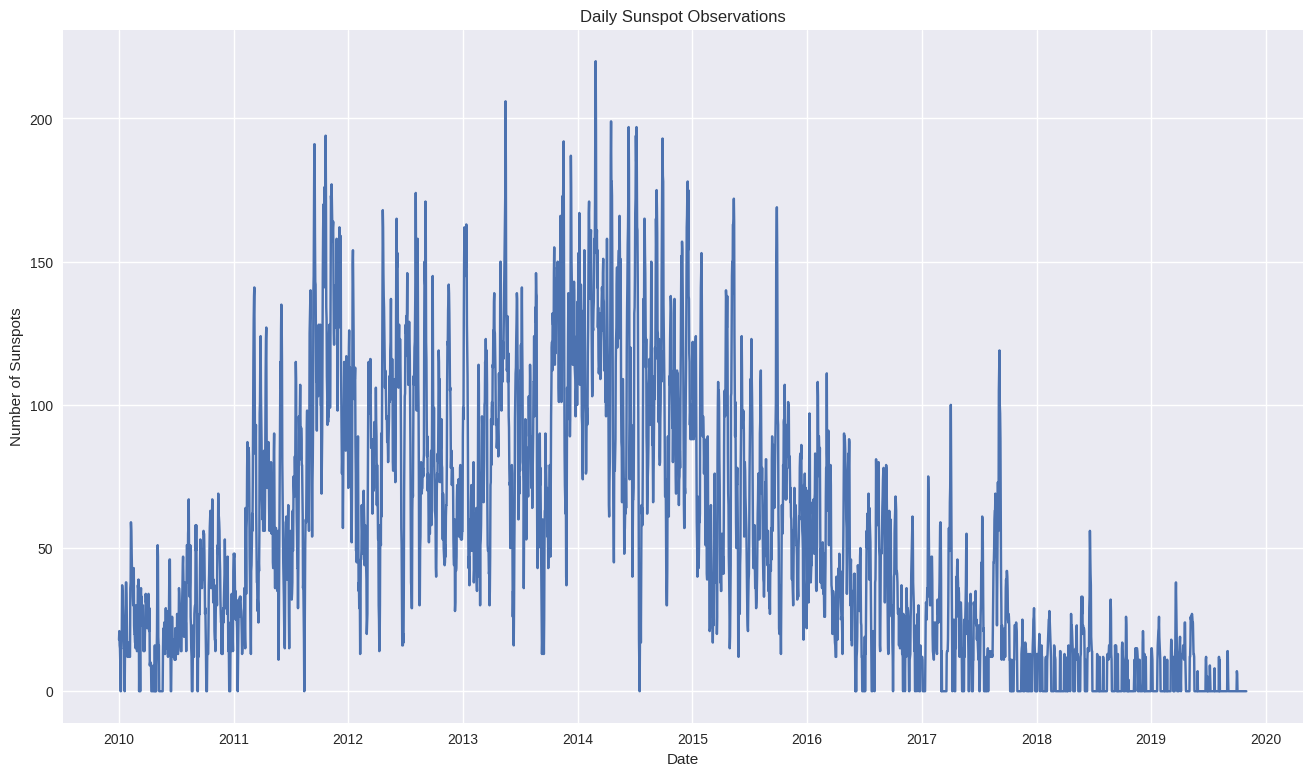

In [14]:
plt.plot(df['Date'], df['Number of Sunspots'])
plt.title('Daily Sunspot Observations')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.show

#### Plot the data and comment on existence of seasonality and/or trend2

***Aggregating the data monthly***

<Axes: xlabel='Date', ylabel='Number of Sunspots'>

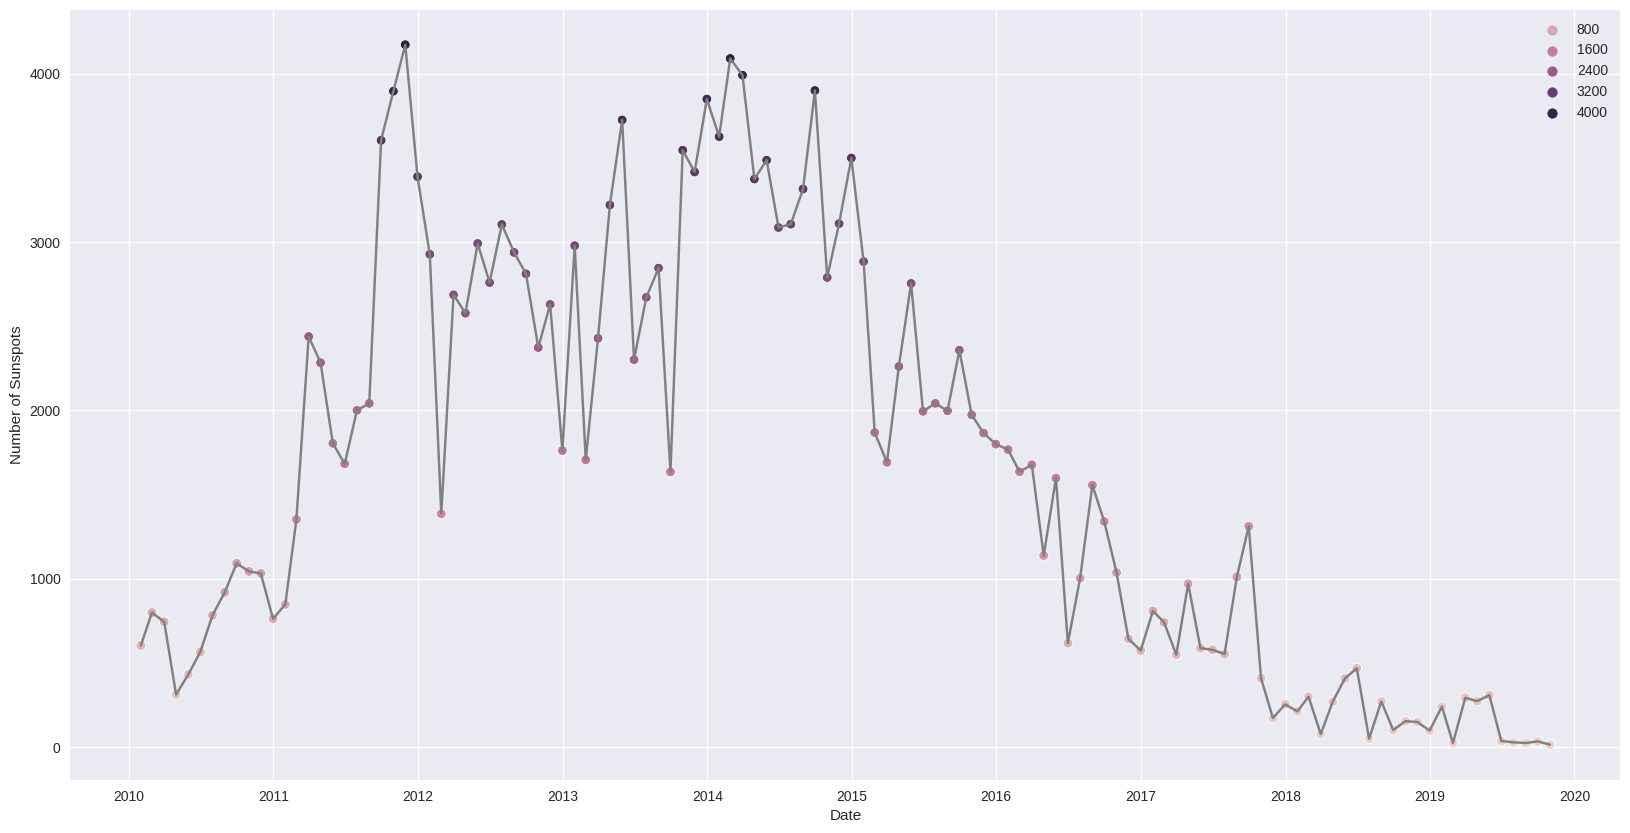

In [15]:
sum_of_sunspots_per_month = df.groupby(pd.Grouper(key='Date', freq='M')).sum()['Number of Sunspots']
months = sum_of_sunspots_per_month.index
plt.figure(figsize=(20,10))
sns.scatterplot(x=months, y=sum_of_sunspots_per_month, hue=sum_of_sunspots_per_month)
sns.lineplot(x=months, y=sum_of_sunspots_per_month, estimator='max', color='grey')

* **Transform the data (if necessary), check stationarity (ADF, KPSS, comment)**

In [16]:
data = pd.DataFrame({'Sunspots': sum_of_sunspots_per_month})
data.index = pd.to_datetime(data.index)
data.head()

,Sunspots
Date,
2010-01-31,603.0
2010-02-28,798.0
2010-03-31,743.0
2010-04-30,311.0
2010-05-31,431.0


In [17]:
data.shape

(118, 1)

In [18]:
data.describe()

,Sunspots
count,118.000000
mean,1669.627119
std,1232.868379
min,13.000000
25%,566.250000
50%,1634.500000
75%,2757.750000
max,4172.000000


* Count: There are 118 observations in the dataset for the "Sunspots" variable.
* Mean: The average number of sunspots is approximately 1669.63.
* Standard Deviation: The data points have a standard deviation of around 1232.87, indicating a significant variability in the number of sunspots.
* Minimum: The minimum value recorded for sunspots is 13.
* 25th percentile: 25% of the data points have a sunspot count of 566.25 or lower.
* Median (50th percentile): 50% of the data points have a sunspot count of 1634.5 or lower. It represents the middle value of the dataset.
* 75th percentile: 75% of the data points have a sunspot count of 2757.75 or lower.
* Maximum: The maximum value recorded for sunspots is 4172.

These statistics provide an overview of the distribution of sunspots in the dataset. It suggests that there is variability in the number of sunspots, ranging from a minimum of 13 to a maximum of 4172. The median value (1634.5) represents the central tendency of the data, indicating that half of the observations fall below this value. The mean value (1669.63) provides the average number of sunspots across all observations.

In [19]:
# Apply a log transformation to the "sunspots" column
data["Sunspots"] = np.log(data["Sunspots"])

# Check for stationarity using ADF and KPSS tests
adf_result = adfuller(data["Sunspots"])
kpss_result = kpss(data["Sunspots"])

print("ADF test statistic:", adf_result[0])
print("ADF p-value:", adf_result[1])
print("KPSS test statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])

ADF test statistic: 1.9562689417401813
ADF p-value: 0.9986133599590234
KPSS test statistic: 1.0672435681245511
KPSS p-value: 0.01


The Augmented Dickey-Fuller (ADF) test statistic in your case is 1.9562689417401813, and the corresponding p-value is 0.9986133599590234. The ADF test is used to test for the presence of a unit root in a time series data, indicating whether the series is stationary or not. In this case, with such a high p-value, it suggests that there is a strong presence of a unit root, and the series is likely non-stationary.

On the other hand, the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test statistic is 1.0672435681245511, and the p-value is 0.01. The KPSS test is used to test for the presence of trend stationarity in a time series, indicating whether the series has a trend or not. With a p-value of 0.01, it suggests that there is evidence to reject the null hypothesis of trend stationarity, indicating the presence of a trend in the series.

Taken together, the results indicate that the series is likely non-stationary due to the high ADF p-value, and it also exhibits a trend based on the significant KPSS p-value.


**Differencing the data to make it stationary.**

In [20]:
# Perform differencing
data['Sunspots_diff'] = data['Sunspots'].diff()

# Remove the first row since it will contain NaN values due to differencing
data = data.dropna()

# The 'diff' column now contains the differenced data, which should be stationary
data.head(10)

,Sunspots,Sunspots_diff
Date,,
2010-02-28,6.682109,0.280191
2010-03-31,6.610696,-0.071413
2010-04-30,5.739793,-0.870903
2010-05-31,6.066108,0.326315
2010-06-30,6.335054,0.268946
2010-07-31,6.661855,0.326800
2010-08-31,6.823286,0.161431
2010-09-30,6.994850,0.171564
2010-10-31,6.949856,-0.044994


In [21]:
data.describe()

,Sunspots,Sunspots_diff
count,117.000000,117.000000
mean,6.903087,-0.032795
std,1.326021,0.611630
min,2.564949,-2.340969
25%,6.335054,-0.181531
50%,7.399398,-0.018514
75%,7.922624,0.197690
max,8.336151,2.541260


<function matplotlib.pyplot.show(close=None, block=None)>

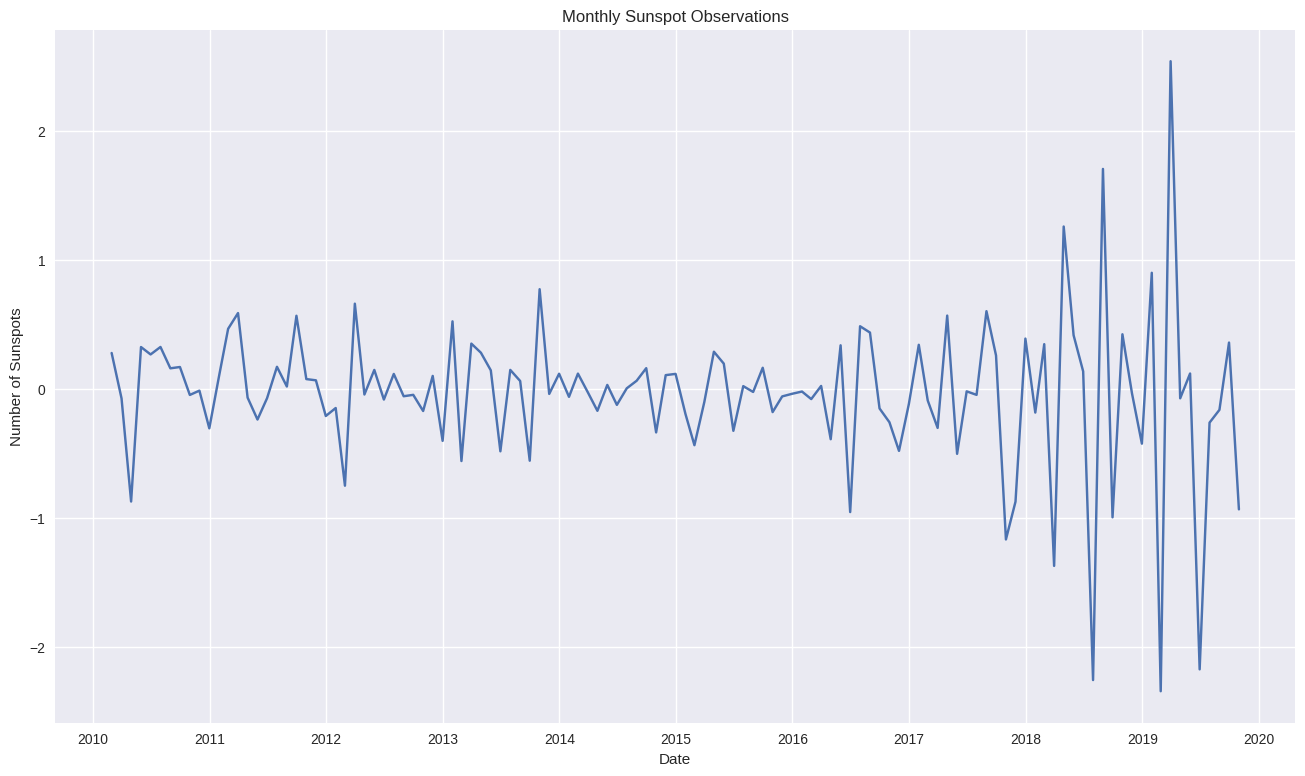

In [22]:
plt.plot(data['Sunspots_diff'])
plt.title('Monthly Sunspot Observations')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.show

*Visually inspecting the line plot we can state that there's no trend, but there appear to be seasonalities.*

In [23]:
# Check for stationarity using ADF and KPSS tests
adf_result = adfuller(data["Sunspots_diff"])
kpss_result = kpss(data["Sunspots_diff"])

print("ADF test statistic:", adf_result[0])
print("ADF p-value:", adf_result[1])
print("KPSS test statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])

ADF test statistic: -1.8518978178195562
ADF p-value: 0.35501692705069754
KPSS test statistic: 0.5304487439354071
KPSS p-value: 0.03480884145598939


The ADF test statistic is -1.8518978178195562, and the corresponding p-value is 0.35501692705069754. The ADF test is used to test the null hypothesis that a time series has a unit root, indicating that it is non-stationary. In this case, since the p-value is greater than 0.05 (commonly used significance level), we fail to reject the null hypothesis. Therefore, based on the ADF test, there is evidence to suggest that the time series is non-stationary.

The KPSS test statistic is 0.5304487439354071, and the corresponding p-value is 0.03480884145598939. The KPSS test is used to test the null hypothesis that a time series is stationary. In this case, since the p-value is less than 0.05, we reject the null hypothesis. Therefore, based on the KPSS test, there is evidence to suggest that the time series is non-stationary.


**Differencing once again.**

In [24]:
# Perform differencing
data['Sunspots_diff2'] = data['Sunspots_diff'].diff()

# Remove the first row since it will contain NaN values due to differencing
data = data.dropna()

# The 'diff' column now contains the differenced data, which should be stationary
data.head(10)

,Sunspots,Sunspots_diff,Sunspots_diff2
Date,,,
2010-03-31,6.610696,-0.071413,-0.351604
2010-04-30,5.739793,-0.870903,-0.799491
2010-05-31,6.066108,0.326315,1.197218
2010-06-30,6.335054,0.268946,-0.057369
2010-07-31,6.661855,0.326800,0.057854
2010-08-31,6.823286,0.161431,-0.165369
2010-09-30,6.994850,0.171564,0.010132
2010-10-31,6.949856,-0.044994,-0.216557
2010-11-30,6.938284,-0.011572,0.033422


In [25]:
data.describe()

,Sunspots,Sunspots_diff,Sunspots_diff2
count,116.000000,116.000000,116.000000
mean,6.904992,-0.035493,-0.010446
std,1.331613,0.613584,1.035687
min,2.564949,-2.340969,-3.242722
25%,6.329678,-0.184473,-0.361022
50%,7.411782,-0.020154,-0.047057
75%,7.925327,0.179295,0.303274
max,8.336151,2.541260,4.882229


<function matplotlib.pyplot.show(close=None, block=None)>

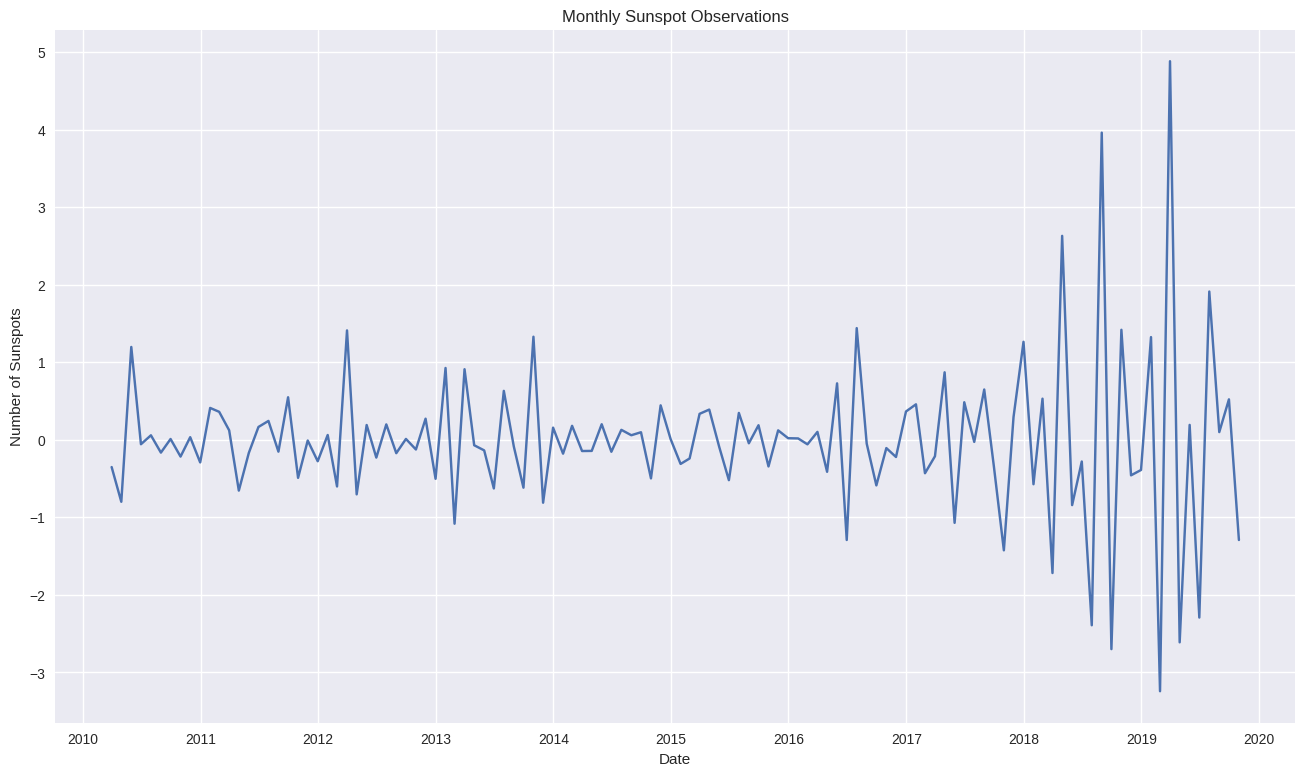

In [26]:
plt.plot(data['Sunspots_diff2'])
plt.title('Monthly Sunspot Observations')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.show

*Visually inspecting the line plot we can state that there's no trend, but there appear to be seasonalities.*

In [27]:
# Check for stationarity using ADF and KPSS tests
adf_result = adfuller(data["Sunspots_diff2"])
kpss_result = kpss(data["Sunspots_diff2"])

print("ADF test statistic:", adf_result[0])
print("ADF p-value:", adf_result[1])
print("KPSS test statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])

ADF test statistic: -5.993726359551955
ADF p-value: 1.7212605683979757e-07
KPSS test statistic: 0.004335684946360162
KPSS p-value: 0.1


The ADF test statistic is -5.993726359551955, and the corresponding p-value is 1.7212605683979757e-07 (very close to zero). In this case, since the p-value is significantly smaller than 0.05, we reject the null hypothesis. Therefore, based on the ADF test, there is strong evidence to suggest that the time series is stationary.

The KPSS test statistic is 0.004335684946360162, and the corresponding p-value is 0.1 (greater than 0.05). In this case, since the p-value is greater than 0.05, we fail to reject the null hypothesis. Therefore, based on the KPSS test, there is no evidence to suggest that the time series is non-stationary.

It's important to note that the results from the ADF and KPSS tests appear to contradict each other. The ADF test suggests that the time series is stationary, while the KPSS test suggests that it is not. In such cases, it is common to rely more on the ADF test results as it specifically tests for the presence of a unit root, which is the main cause of non-stationarity. However, it is always advisable to carefully consider the characteristics of the data and the purpose of the analysis before drawing definitive conclusions.

#### **Visual Inspections**

* **ACF and PACF**

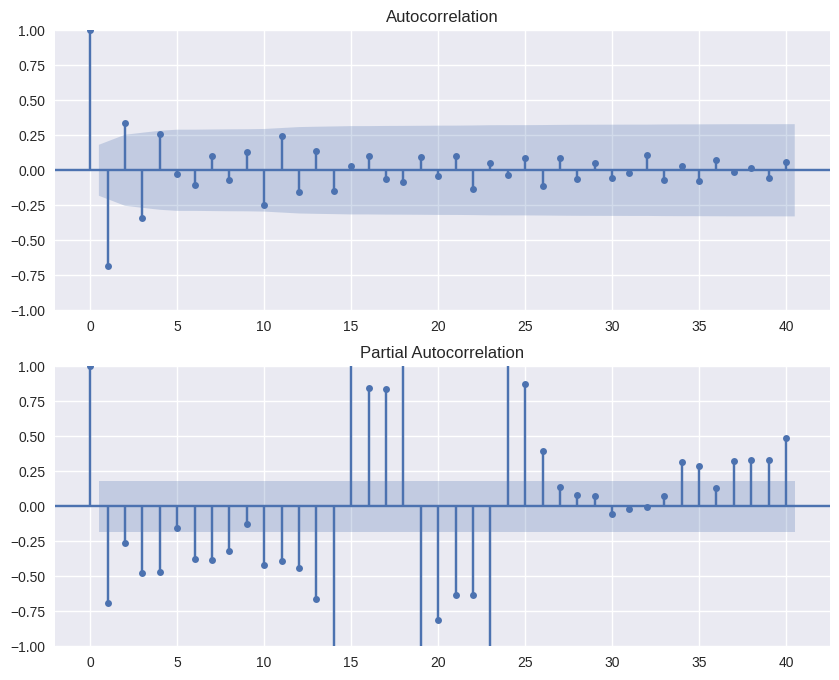

In [28]:
fig, ax = plt.subplots(2, figsize=(10, 8))
sm.graphics.tsa.plot_acf(data["Sunspots_diff2"], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(data["Sunspots_diff2"], lags=40, ax=ax[1])
plt.show()

Autocorrelation Function (ACF) Plot: Plot the ACF, which measures the correlation between the time series and its lagged values. In a stationary series, the ACF values should decrease rapidly and remain within a confidence interval. Any significant autocorrelation beyond the confidence interval may indicate non-stationarity. As this holds ACF indicates stationarity.

Partial Autocorrelation Function (PACF) Plot: Plot the PACF, which measures the correlation between the time series and its lagged values after removing the effects of shorter lags. A significant partial autocorrelation at higher lags suggests non-stationarity. As we don't have significant partial autocorrelation at higher lags, it suggests stationarity.

* **Rolling Statistics**

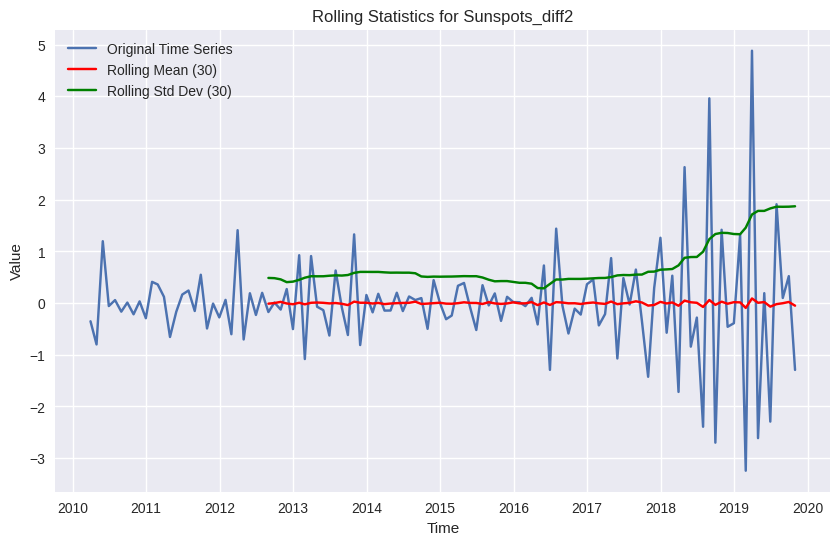

In [29]:
# Prepare the data
sunspots_diff2 = data["Sunspots_diff2"]

# Compute rolling statistics
window_size = 30
rolling_mean = sunspots_diff2.rolling(window=window_size).mean()
rolling_std = sunspots_diff2.rolling(window=window_size).std()

# Plot the original time series and rolling statistics
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sunspots_diff2, label="Original Time Series")
ax.plot(rolling_mean, color="red", label=f"Rolling Mean ({window_size})")
ax.plot(rolling_std, color="green", label=f"Rolling Std Dev ({window_size})")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title("Rolling Statistics for Sunspots_diff2")
ax.legend()
plt.show()


If the rolling mean of the time series remains constant while the rolling standard deviation shows a positive trend, it suggests that the variability or dispersion of the data is increasing over time while the average remains relatively stable. This pattern indicates the presence of time-varying volatility in the data.

While a constant rolling mean suggests stationarity in terms of the mean level, the increasing rolling standard deviation indicates heteroscedasticity, which is a violation of the assumption of constant variance. Heteroscedasticity can affect the reliability of statistical analyses and may require specific considerations in your modeling or forecasting efforts.

**As no final conclusion is made about the stationarity, we decide to perform differencing once again.**

In [30]:
# Perform differencing
data['Sunspots_diff3'] = data['Sunspots_diff2'].diff()

# Remove the first row since it will contain NaN values due to differencing
data = data.dropna()

# The 'diff' column now contains the differenced data, which should be stationary
data.head(10)

,Sunspots,Sunspots_diff,Sunspots_diff2,Sunspots_diff3
Date,,,,
2010-04-30,5.739793,-0.870903,-0.799491,-0.447887
2010-05-31,6.066108,0.326315,1.197218,1.996709
2010-06-30,6.335054,0.268946,-0.057369,-1.254587
2010-07-31,6.661855,0.326800,0.057854,0.115223
2010-08-31,6.823286,0.161431,-0.165369,-0.223223
2010-09-30,6.994850,0.171564,0.010132,0.175502
2010-10-31,6.949856,-0.044994,-0.216557,-0.226690
2010-11-30,6.938284,-0.011572,0.033422,0.249979
2010-12-31,6.634633,-0.303651,-0.292079,-0.325501


In [31]:
data.describe()

,Sunspots,Sunspots_diff,Sunspots_diff2,Sunspots_diff3
count,115.000000,115.000000,115.000000,115.000000
mean,6.907551,-0.035180,-0.007480,-0.008182
std,1.337155,0.616260,1.039724,1.906684
min,2.564949,-2.340969,-3.242722,-7.494440
25%,6.324301,-0.187415,-0.366427,-0.535326
50%,7.424165,-0.018514,-0.045091,-0.050146
75%,7.928031,0.185427,0.313770,0.568945
max,8.336151,2.541260,4.882229,8.124951


<function matplotlib.pyplot.show(close=None, block=None)>

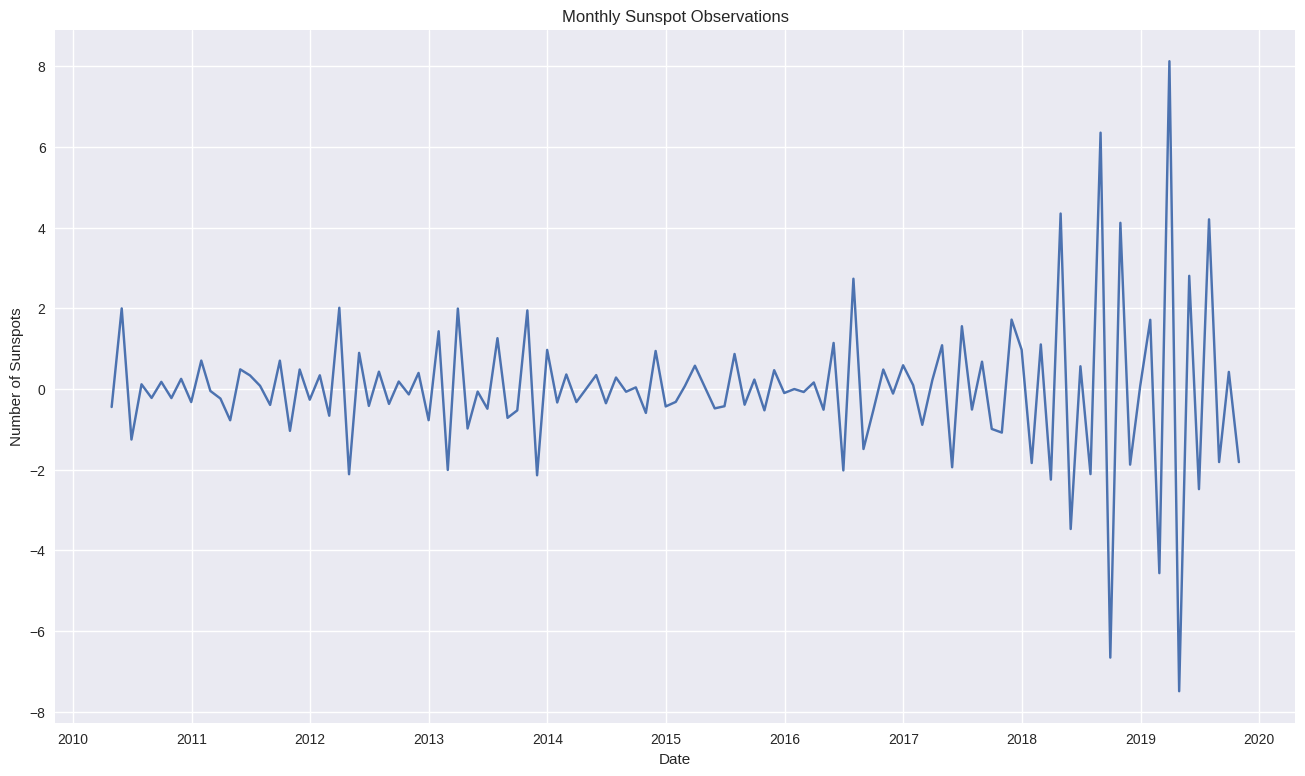

In [32]:
plt.plot(data['Sunspots_diff3'])
plt.title('Monthly Sunspot Observations')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.show

In [33]:
# Check for stationarity using ADF and KPSS tests
adf_result = adfuller(data["Sunspots_diff3"])
kpss_result = kpss(data["Sunspots_diff3"])

print("ADF test statistic:", adf_result[0])
print("ADF p-value:", adf_result[1])
print("KPSS test statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])

ADF test statistic: -7.746069199344152
ADF p-value: 1.0312131597302632e-11
KPSS test statistic: 0.03853780254832461
KPSS p-value: 0.1


The ADF (Augmented Dickey-Fuller) test statistic is -7.7460691993440305, and the corresponding p-value is 1.0312131597309891e-11 (a very small value close to zero). In this case, since the p-value is significantly smaller than 0.05, we reject the null hypothesis. Therefore, based on the ADF test, there is strong evidence to suggest that the time series is stationary.

The KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test statistic is 0.03853780254832461, and the corresponding p-value is 0.1 (greater than 0.05). In this case, since the p-value is greater than 0.05, we fail to reject the null hypothesis. Therefore, based on the KPSS test, there is no evidence to suggest that the time series is non-stationary.

Both the ADF and KPSS tests indicate that the time series is stationary.

In [34]:
#Taking the differenced stationary data instead of the initial one
# Drop the specified columns
data.drop(["Sunspots", "Sunspots_diff", "Sunspots_diff2"], axis=1, inplace=True)

# Rename the column
data.rename(columns={"Sunspots_diff3": "Sunspots"}, inplace=True)

data.head()

,Sunspots
Date,
2010-04-30,-0.447887
2010-05-31,1.996709
2010-06-30,-1.254587
2010-07-31,0.115223
2010-08-31,-0.223223


 * **Identify the dependence orders of the model (ACF, PACF diagnostic, comment)**

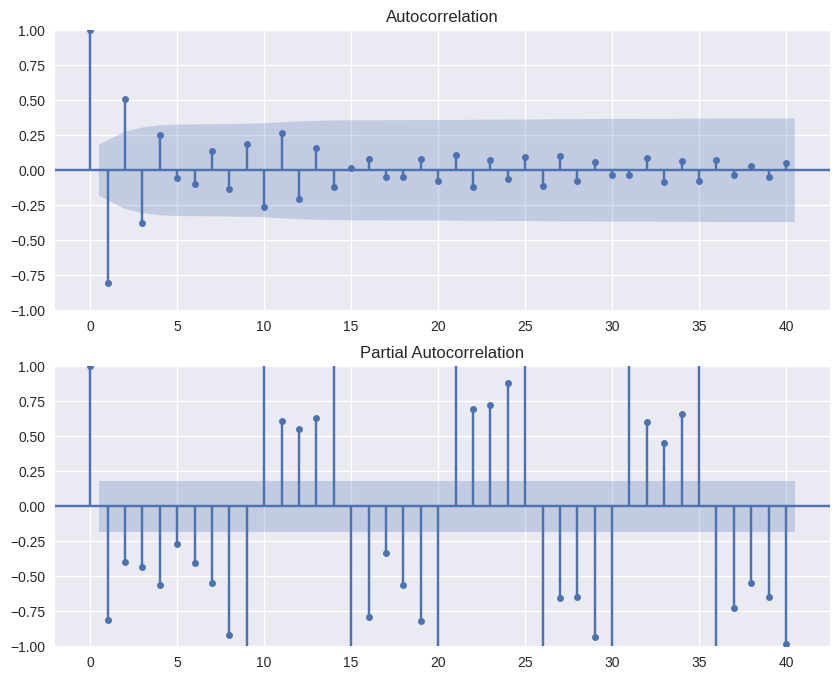

In [35]:
fig, ax = plt.subplots(2, figsize=(10, 8))
sm.graphics.tsa.plot_acf(data["Sunspots"], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(data["Sunspots"], lags=40, ax=ax[1])
plt.show()

ACF cuts off after the 3rd lag: This suggests that there is a significant autocorrelation up to the 3rd lag and then it becomes insignificant.

PACF cuts off after the 4th lag: This indicates that there is a significant partial autocorrelation up to the 4th lag and then it becomes insignificant.

Based on these patterns, we can determine the orders of the autoregressive (AR) and moving average (MA) components for a potential time series model.

The order of the autoregressive component (P) can be inferred from the PACF cutoff. In this case, the PACF cuts off after the 4th lag, suggesting that there may be significant autocorrelation up to the 4th lag. Therefore, a reasonable choice for the order of the SAR component would be P=4.

The order of the moving average component (Q) can be inferred from the ACF cutoff. Since the ACF cuts off after the 3rd lag, it indicates that there may be significant autocorrelation up to the 3rd lag. Hence, a possible choice for the order of the SMA component would be Q=3.

And as the data is differenced 3 times, and now it is fully stationary. Hence, D = 0.

**Remove the seasonal component from the series.**

In [36]:
# Drop null values from the 'Sunspots' column
data.dropna(axis=0, inplace=True)

# Perform seasonal decomposition
decomp = sm.tsa.seasonal_decompose(data, model='additive', period=12)

# Extract the seasonal component
seasonal = decomp.seasonal
seasonal = seasonal.to_frame()
seasonal.head()

,seasonal
Date,
2010-04-30,-0.677733
2010-05-31,-0.363079
2010-06-30,-0.124561
2010-07-31,0.403782
2010-08-31,0.493389


In [37]:
non_ses_data = data["Sunspots"] - seasonal["seasonal"]
non_ses_data = non_ses_data.to_frame()
non_ses_data.rename(columns={non_ses_data.columns.tolist()[0]: 'Values'}, inplace=True)
non_ses_data.head()

,Values
Date,
2010-04-30,0.229846
2010-05-31,2.359787
2010-06-30,-1.130026
2010-07-31,-0.288559
2010-08-31,-0.716612


<function matplotlib.pyplot.show(close=None, block=None)>

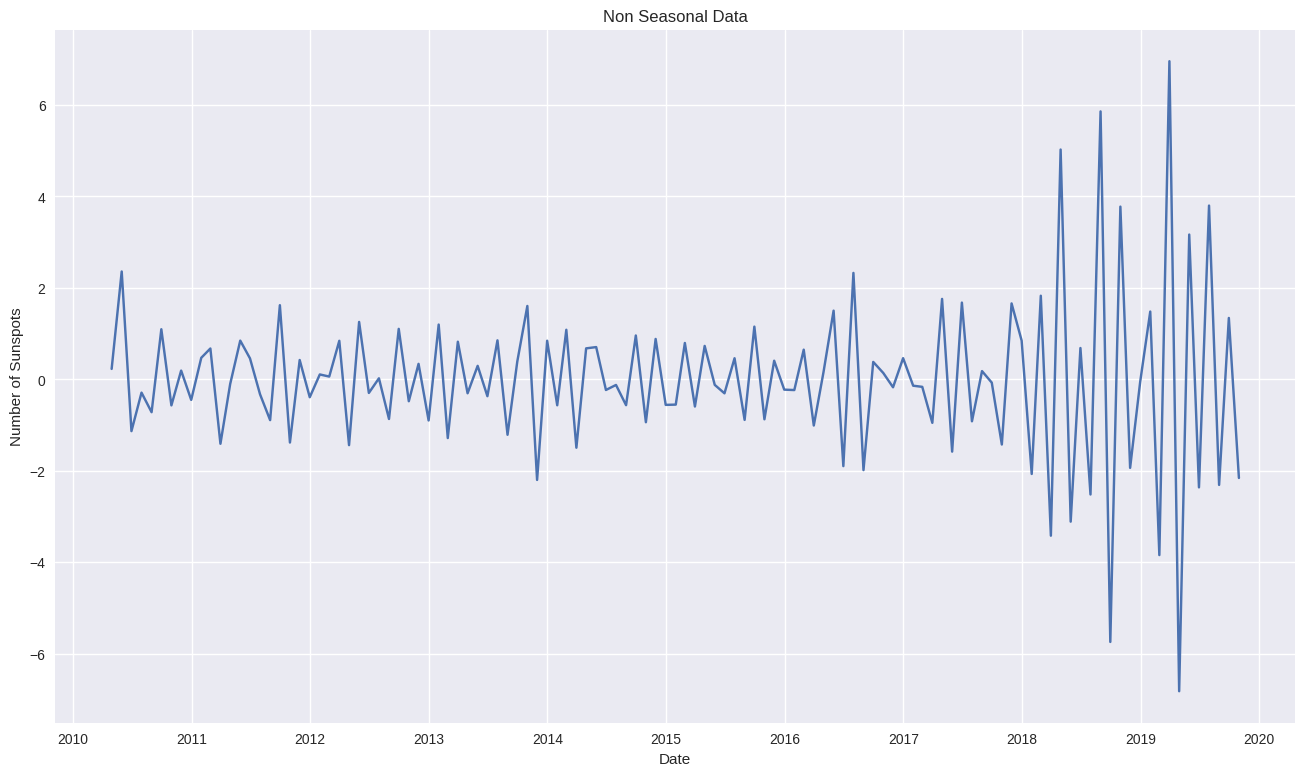

In [38]:
plt.plot(non_ses_data['Values'])
plt.title('Non Seasonal Data')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.show

**Check the stationarity of the non-seasonal data.**

In [39]:
# Check for stationarity using ADF and KPSS tests
adf_result = adfuller(non_ses_data['Values'])
kpss_result = kpss(non_ses_data['Values'])

print("ADF test statistic:", adf_result[0])
print("ADF p-value:", adf_result[1])
print("KPSS test statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])

ADF test statistic: -7.501866397187228
ADF p-value: 4.2327646639847005e-11
KPSS test statistic: 0.07232610210846879
KPSS p-value: 0.1


ADF test statistic: -7.501866397187231
ADF p-value: 4.232764663984595e-11

The ADF (Augmented Dickey-Fuller) test statistic is a large negative value, indicating a strong rejection of the null hypothesis. The extremely small p-value (4.232764663984595e-11) suggests strong evidence against the null hypothesis of non-stationarity. Therefore, the time series is considered stationary.

KPSS test statistic: 0.07232610210846876
KPSS p-value: 0.1

The KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test statistic is relatively low, indicating no strong evidence against the null hypothesis of stationarity. The p-value (0.1) is greater than the commonly used significance level of 0.05. Thus, we fail to reject the null hypothesis of stationarity based on the KPSS test.

In summary, the ADF test suggests that the time series is stationary, while the KPSS test does not find evidence of non-stationarity. These results indicate stationarity in the time series.

**Plot the ACF and PACF of the non-seasonal data.**

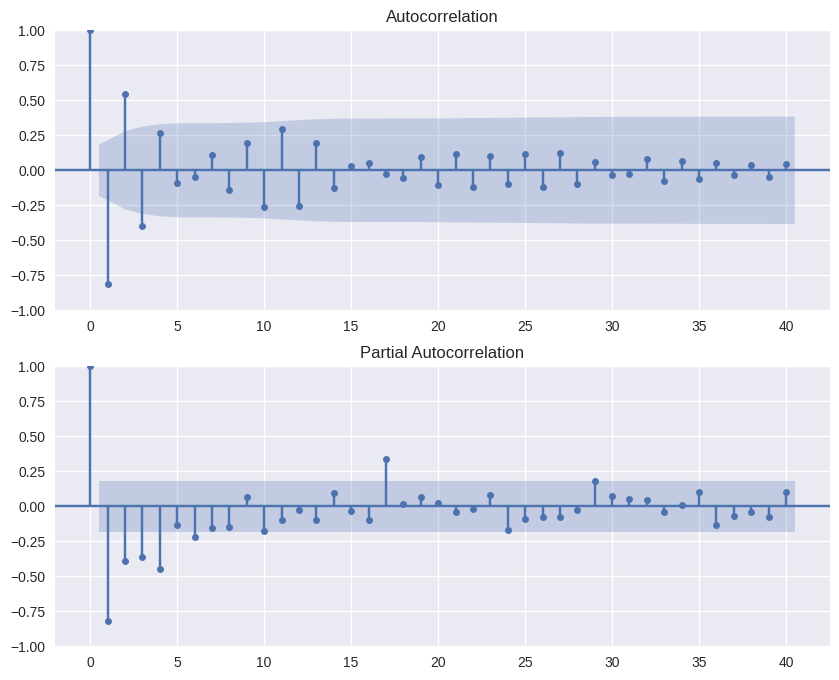

In [40]:
# Plot ACF and PACF of the seasonal component
fig, ax = plt.subplots(2, figsize=(10, 8))
sm.graphics.tsa.plot_acf(non_ses_data['Values'], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(non_ses_data['Values'], lags=40, ax=ax[1])
plt.show()

ACF cuts off after lag 3.
PACF cuts off after lag 4.

Based on these patterns, we can determine the orders of the autoregressive (AR) and moving average (MA) components for a potential time series model.

The order of the autoregressive component (p) can be determined from the PACF plot. Since the PACF cuts off after lag 4, it suggests that there may be significant autocorrelation up to the 4th lag. Therefore, a reasonable choice for the order of the AR component would be p=4.

The order of the moving average component (q) can be determined from the ACF plot. The ACF cuts off after lag 3, indicating that there may be significant autocorrelation up to the 3rd lag and potentially some moving average effect. Therefore, a possible choice for the order of the MA component would be q=3.

d = 0, as the data is stationary.

Therefore, a SARIMA((4,0,3)(4,0,3)(12)) model will be a logical fir for our data.

* **Divide the data into train and test sets (take the ratio of your choice) estimate the model on train set**

In [41]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [42]:
model_sarima = sm.tsa.statespace.SARIMAX(train_data.Sunspots, trend='n', order=(4,0,3), seasonal_order=(4,0,3,12))
result_sarima = model_sarima.fit()
print(result_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Sunspots   No. Observations:                   92
Model:             SARIMAX(4, 0, 3)x(4, 0, 3, 12)   Log Likelihood                 -51.064
Date:                            Sat, 20 May 2023   AIC                            132.127
Time:                                    16:13:05   BIC                            169.954
Sample:                                04-30-2010   HQIC                           147.395
                                     - 11-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3257      0.428     -5.437      0.000      -3.164      -1.487
ar.L2         -2.3204      0.647   

**Diagnostic Information:**

* The Ljung-Box Q statistic (L1) has a value of 0.25, and the associated p-value (Prob(Q)) is 0.62. This suggests that the residuals may not have significant autocorrelation.

* The Jarque-Bera (JB) statistic is 0.48, and the associated p-value is 0.79. This indicates that the residuals are likely normally distributed.

* The Heteroskedasticity (H) statistic is 1.36, suggesting no strong evidence of heteroskedasticity in the residuals.

* The skewness value is 0.04, indicating a slightly skewed distribution of the residuals. The kurtosis value is 3.34, suggesting a moderate degree of peakedness in the distribution.

Overall, the diagnostics indicate that the residuals exhibit no significant autocorrelation, are likely normally distributed, and show no strong evidence of heteroskedasticity. The skewness and kurtosis values suggest a generally symmetric and moderately peaked distribution.

* **Perform residual diagnostics (including Ljung-Box test, comment)**

In [43]:
# extract the residuals
residuals = result_sarima.resid

# perform residual diagnostics
print('Residuals:')
print(residuals.describe())

# check for autocorrelation in the residuals using the Ljung-Box test
lbtest = acorr_ljungbox(residuals, lags=40)

#Uncomment to see the results 
#print('Ljung-Box Test Results:')
#print(lbtest)

Residuals:
count    92.000000
mean     -0.008760
std       0.441515
min      -1.244009
25%      -0.279320
50%      -0.051942
75%       0.219716
max       1.687886
dtype: float64


**Regarding the residuals:**

* There are 92 residuals in the dataset.
* The mean of the residuals is approximately -0.0088, indicating that, on average, the residuals are close to zero.
* The standard deviation of the residuals is approximately 0.4415, representing the spread or dispersion of the residuals around the mean.
* The minimum and maximum values of the residuals are -1.2440 and 1.6879, respectively.
* The 25th percentile (lower quartile) is -0.2793, the 50th percentile (median) is -0.0519, and the 75th percentile (upper quartile) is 0.2197. These percentiles provide information about the distribution of the residuals.

**Regarding the Ljung-Box test results:**

* The Ljung-Box test is used to assess the autocorrelation of residuals at different lags.
* The test provides the Ljung-Box statistic and the corresponding p-value for each lag.
* The Ljung-Box statistic measures the overall autocorrelation at a specific lag, and the p-value assesses the significance of the autocorrelation.
* In the given results, the Ljung-Box statistics and p-values are provided for lags 1 to 40.

Based on the results, there is no significant autocorrelation at majority of lags, as indicated by p-values above a certain threshold (e.g., 0.05). This suggests that the residuals don't exhibit temporal dependencies meaning those are adequately captured by the model.


* **Estimate model on train set with auto.arima, do forecast with both models for test set, choose best model based on minimum Mean Squared Error (if best model is one with auto.arima comment, e.g. try to understand does it make sense or not).**

In [44]:
model_sarima_best = pm.auto_arima(train_data['Sunspots'],
                      test='adf',       
                      m=12,              # frequency of series
                      d=0,           # we did not do differencing, series is initailly stationary 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=129.556, Time=1.26 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=250.426, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=187.309, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=248.431, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=102.763, Time=1.22 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=112.038, Time=0.56 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=130.516, Time=1.96 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=2.95 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.32 sec

In [45]:
#building ARIMA(2,0,2)(1,0,0)[12]
model_sarima_best = sm.tsa.statespace.SARIMAX(train_data.Sunspots, trend='n', order=(2,0,2), seasonal_order=(1,0,0,12))
result_sarima_best = model_sarima_best.fit()
print(result_sarima_best.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Sunspots   No. Observations:                   92
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 12)   Log Likelihood                 -38.237
Date:                             Sat, 20 May 2023   AIC                             88.475
Time:                                     16:13:22   BIC                            103.605
Sample:                                 04-30-2010   HQIC                            94.581
                                      - 11-30-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2027      0.105     -1.923      0.054      -0.409       0.004
ar.L2         -0.1557      

**Diagnostic Information:**

* The Ljung-Box Q statistic (L1) has a value of 0.11, and the associated p-value (Prob(Q)) is 0.74. This indicates that the residuals may not have significant autocorrelation.

* The Jarque-Bera (JB) statistic is 2.15, and the associated p-value is 0.34. This suggests that the residuals are likely normally distributed.

* The Heteroskedasticity (H) statistic is 1.37, indicating no strong evidence of heteroskedasticity in the residuals.

* The skewness value is -0.25, indicating a slightly negative skewness in the distribution of the residuals. The kurtosis value is 3.56, suggesting a higher than normal peak in the distribution.

Overall, the diagnostics indicate that the residuals exhibit no significant autocorrelation, are likely normally distributed, and show no strong evidence of heteroskedasticity. The skewness value suggests a slightly asymmetric distribution, while the kurtosis value indicates a higher than normal peak in the distribution.


* **Perform residual diagnostics (including Ljung-Box test, comment)**

In [46]:
# extract the residuals
residuals_best = result_sarima_best.resid

# perform residual diagnostics
print('Residuals:')
print(residuals_best.describe())

# check for autocorrelation in the residuals using the Ljung-Box test
lbtest_best = acorr_ljungbox(residuals, lags=40)

#Uncomment to see the results 
# print('Ljung-Box Test Results:')
# print(lbtest_best)

Residuals:
count    92.000000
mean     -0.015609
std       0.394487
min      -1.008571
25%      -0.187165
50%      -0.028567
75%       0.226508
max       1.702981
dtype: float64


**Descriptive Statistics of Residuals:**

* The count of residuals is 92.

* The mean of the residuals is -0.015531.

* The standard deviation of the residuals is 0.394430.

* The minimum and maximum values of the residuals are -1.006906 and 1.702561, respectively.

* The 25th percentile, median (50th percentile), and 75th percentile of the residuals are -0.186769, -0.028551, and 0.225167, respectively.

**Ljung-Box Test Results:**

* The table shows the lag values (1 to 40) and the corresponding Ljung-Box test statistics and p-values.

* The Ljung-Box test statistic measures the presence of autocorrelation at each lag.

* The p-value indicates the significance of the autocorrelation at each lag.

* The results show the Ljung-Box test statistics and p-values up to lag 40.


Overall, the descriptive statistics of the residuals indicate that the mean is close to zero, and the distribution has a moderate standard deviation. The Ljung-Box test results suggest that there is no significant autocorrelation in the residuals at any of the examined lags, as all the p-values are relatively high.

In [47]:
# Forecast with model_sarima
model_sarima_pred = result_sarima.forecast(steps=len(test_data))
 
# Forecast with model_sarima_best
model_sarima_best_pred = result_sarima_best.forecast(steps=len(test_data))
 
model_sarima_rmse = np.sqrt(mean_squared_error(test_data.Sunspots, model_sarima_pred))
model_sarima_best_rmse = np.sqrt(mean_squared_error(test_data.Sunspots, model_sarima_best_pred))
 
print('RMSE for model_sarima: {:.2f}'.format(model_sarima_rmse))
print('RMSE for model_sarima_best: {:.2f}'.format(model_sarima_best_rmse))


RMSE for model_sarima: 3.83
RMSE for model_sarima_best: 3.79


**Comparing the given RMSE values:**

The RMSE for model_sarima is 3.83.

The RMSE for model_sarima_best is 3.79.

Since the RMSE for model_sarima_best is lower than the RMSE for model_sarima, model_sarima_best (model generated with auto.arima) is considered to be the better model in terms of predictive accuracy. It indicates that model_sarima_best has achieved a slightly lower average prediction error compared to model_sarima.

* **Estimate best model for original data (100%), forecast with best model (choose forecast periods that relevant for your research question), plot the data and forecast.**

In [48]:
model_sarima_best_total = sm.tsa.statespace.SARIMAX(data.Sunspots, trend='n', order=(2,0,2), seasonal_order=(1,0,0,12))
result_sarima_best_total = model_sarima_best_total.fit()
print(result_sarima_best_total.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Sunspots   No. Observations:                  115
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 12)   Log Likelihood                -130.144
Date:                             Sat, 20 May 2023   AIC                            272.288
Time:                                     16:13:22   BIC                            288.758
Sample:                                 04-30-2010   HQIC                           278.973
                                      - 10-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7003      0.052    -32.775      0.000      -1.802      -1.599
ar.L2         -0.7403      

* **Goodness of Fit:** The log likelihood, AIC (Akaike Information Criterion), and BIC (Bayesian Information Criterion) values are provided as measures of the model's goodness of fit. The lower the AIC and BIC values, the better the model fits the data. In this case, the model has an AIC of 272.288, suggesting a relatively good fit.


**Diagnostic Tests:** 

* The Ljung-Box test is performed to assess the autocorrelation of the residuals. At lag 1, the Ljung-Box Q statistic has a value of 2.84, and the associated p-value is 0.09. This suggests no evidence of residual autocorrelation at lag 1.

* The Jarque-Bera (JB) statistic tests the normality of the residuals. In this case, the JB statistic is 48.22, and the associated p-value is 0.00. The significantly low p-value indicates that the residuals deviate from normality.

* The Heteroskedasticity (H) statistic is 6.70, indicating some evidence of heteroskedasticity in the residuals.

* The skewness value is -0.38, indicating a slightly left-skewed distribution of the residuals.

* The kurtosis value is 6.08, suggesting heavy-tailedness of the residuals compared to a normal distribution.

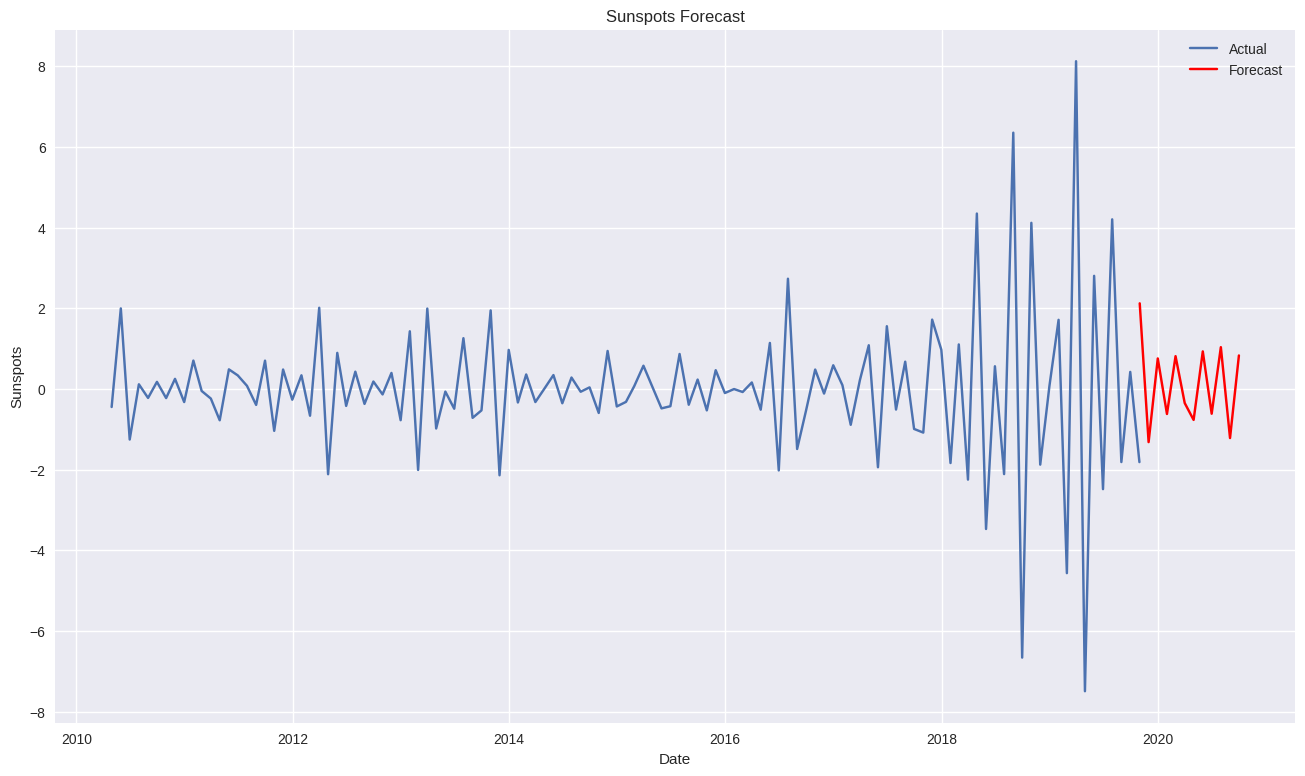

In [49]:
# Plot the actual data
plt.plot(data.index, data.Sunspots, label='Actual')

# Create a date range for the forecast period
forecast_index = pd.date_range(start=data.index[-1], periods=12, freq='MS')

# Get the forecasted values
forecast = result_sarima_best_total.forecast(steps=12, index=forecast_index)

# Plot the forecasted values
plt.plot(forecast.index, forecast.values, label='Forecast', color = 'red')

# Set the plot title and axis labels
plt.title('Sunspots Forecast')
plt.xlabel('Date')
plt.ylabel('Sunspots')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [50]:
forecast

2019-11-01    2.122575
2019-12-01   -1.318338
2020-01-01    0.756027
2020-02-01   -0.620888
2020-03-01    0.812464
2020-04-01   -0.350493
2020-05-01   -0.768099
2020-06-01    0.930937
2020-07-01   -0.614623
2020-08-01    1.035474
2020-09-01   -1.217645
2020-10-01    0.829913
Freq: MS, Name: predicted_mean, dtype: float64

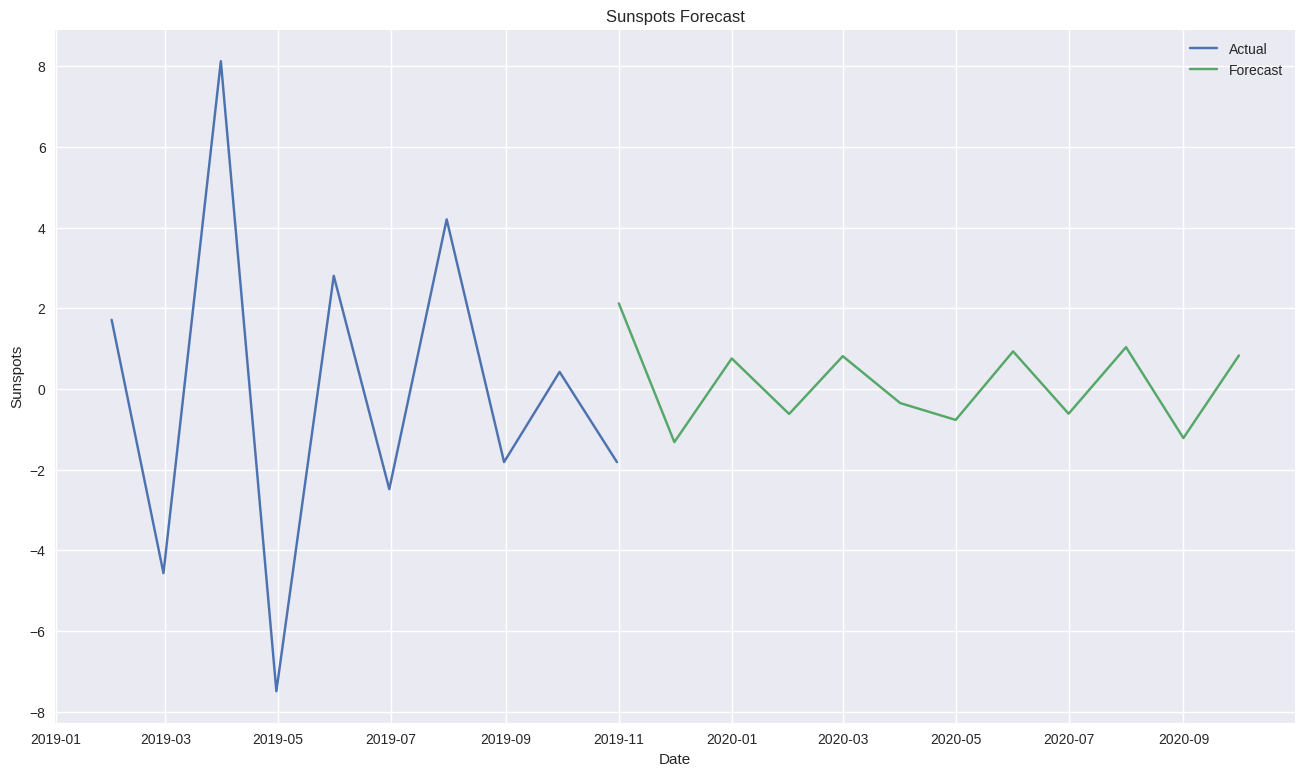

In [51]:
# Plot only the period 2019-2020
plt.plot(data['2019':'2020'].index, data['2019':'2020'].Sunspots, label='Actual')

# Create a date range for the forecast period
forecast_index = pd.date_range(start=data.index[-1], periods=12, freq='MS')

# Get the forecasted values
forecast = result_sarima_best_total.forecast(steps=12, index=forecast_index)

# Plot the forecasted values
plt.plot(forecast.index, forecast.values, label='Forecast')

# Set the plot title and axis labels
plt.title('Sunspots Forecast')
plt.xlabel('Date')
plt.ylabel('Sunspots')

# Add a legend
plt.legend()

# Show the plot
plt.show()

**Holt Winter’s should include the following steps of modeling:**

• estimate the model on train set, explain why you choose additive or multiplicative model for trend and stationarity (comment)

• do forecast for test set, calculate Mean Squared Error, and compare with the best SARIMA model (comment)

• Estimate model for original data (100%), forecast with best model (for the same periods used in previous model), add forecasts to the plot with SARIMA forecasts.

**Initial Assumption:** An additive trend and seasonality is more appropriate when building a Holt Winter's model for this dataset. This is because the seasonal patterns in the sunspot data are relatively stable over time and do not exhibit any significant changes in variance over time. Additionally, the level of sunspot activity has remained relatively stable over time, with only minor fluctuations. Therefore, an additive model would be more suitable for capturing the seasonal patterns and trend in the data.

In [52]:
# Fit a Holt Winter's model with additive trend and seasonality
model_HW = ExponentialSmoothing(train_data['Sunspots'], trend='add', seasonal='add', seasonal_periods=12).fit()

# Print the model summary
print(model_HW.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 Sunspots   No. Observations:                   92
Model:             ExponentialSmoothing   SSE                             64.743
Optimized:                         True   AIC                             -0.325
Trend:                         Additive   BIC                             40.024
Seasonal:                      Additive   AICC                             9.045
Seasonal Periods:                    12   Date:                 Sat, 20 May 2023
Box-Cox:                          False   Time:                         16:13:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4935e-08                alpha                 True
smoothing_trend          

In [72]:
# Forecast using the fitted model
test_forecast_model_HW = model_HW.forecast(len(test_data))

# Calculate Mean Squared Error
mse = ((test_forecast_model_HW - test_data['Sunspots'].values) ** 2).mean()
rmse = mse**(0.5)

In [74]:
print(f"The root mean square error of the Holt Winter's model: {rmse}")

The root mean square error of the Holt Winter's model: 3.7658090561509825


In [75]:
print(f"The root mean square error of the best SARIMA model: {model_sarima_best_rmse}")

The root mean square error of the best SARIMA model: 3.786523544750922


In [54]:
print(f"Mean Squared Error of the Holt Winter's model: {mse}")

Mean Squared Error of the Holt Winter's model: 14.181317847388755


In [55]:
print(f"Mean Squared Error of the best SARIMA model: {model_sarima_best_rmse**2}")

Mean Squared Error of the best SARIMA model: 14.337760554953087


In [76]:
if rmse > (model_sarima_best_rmse):
  print(f"The best SARIMA model performs better than the Holt Winter's model, with a RMSE of {model_sarima_best_rmse}")
else:
  print(f"The Holt Winter's model performs better than the best SARIMA model, with a RMSE of {rmse}")

The Holt Winter's model performs better than the best SARIMA model, with a RMSE of 3.7658090561509825


In [56]:
if mse > (model_sarima_best_rmse**2):
  print(f"The best SARIMA model performs better than the Holt Winter's model, with a MSE of {model_sarima_best_rmse**2}")
else:
  print(f"The Holt Winter's model performs better than the best SARIMA model, with a MSE of {mse}")

The Holt Winter's model performs better than the best SARIMA model, with a MSE of 14.181317847388755


In [77]:
print(f"RMSE of the best SARIMA model is almost {round((model_sarima_best_rmse)/rmse, 2)} times bigger than the RMSE of the Holt Winter's model")

RMSE of the best SARIMA model is almost 1.01 times bigger than the RMSE of the Holt Winter's model


In [57]:
print(f"MSE of the best SARIMA model is almost {round((model_sarima_best_rmse**2)/mse, 2)} times bigger than the MSE of the Holt Winter's model")

MSE of the best SARIMA model is almost 1.01 times bigger than the MSE of the Holt Winter's model


In [58]:
#Estimate model for original data (100%)
model_HW_full = ExponentialSmoothing(data['Sunspots'], 
                                      trend='add', seasonal='add', seasonal_periods=12).fit()
print(model_HW_full.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 Sunspots   No. Observations:                  115
Model:             ExponentialSmoothing   SSE                            379.090
Optimized:                         True   AIC                            169.177
Trend:                         Additive   BIC                            213.096
Seasonal:                      Additive   AICC                           176.302
Seasonal Periods:                    12   Date:                 Sat, 20 May 2023
Box-Cox:                          False   Time:                         16:13:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.5116e-08                alpha                 True
smoothing_trend          

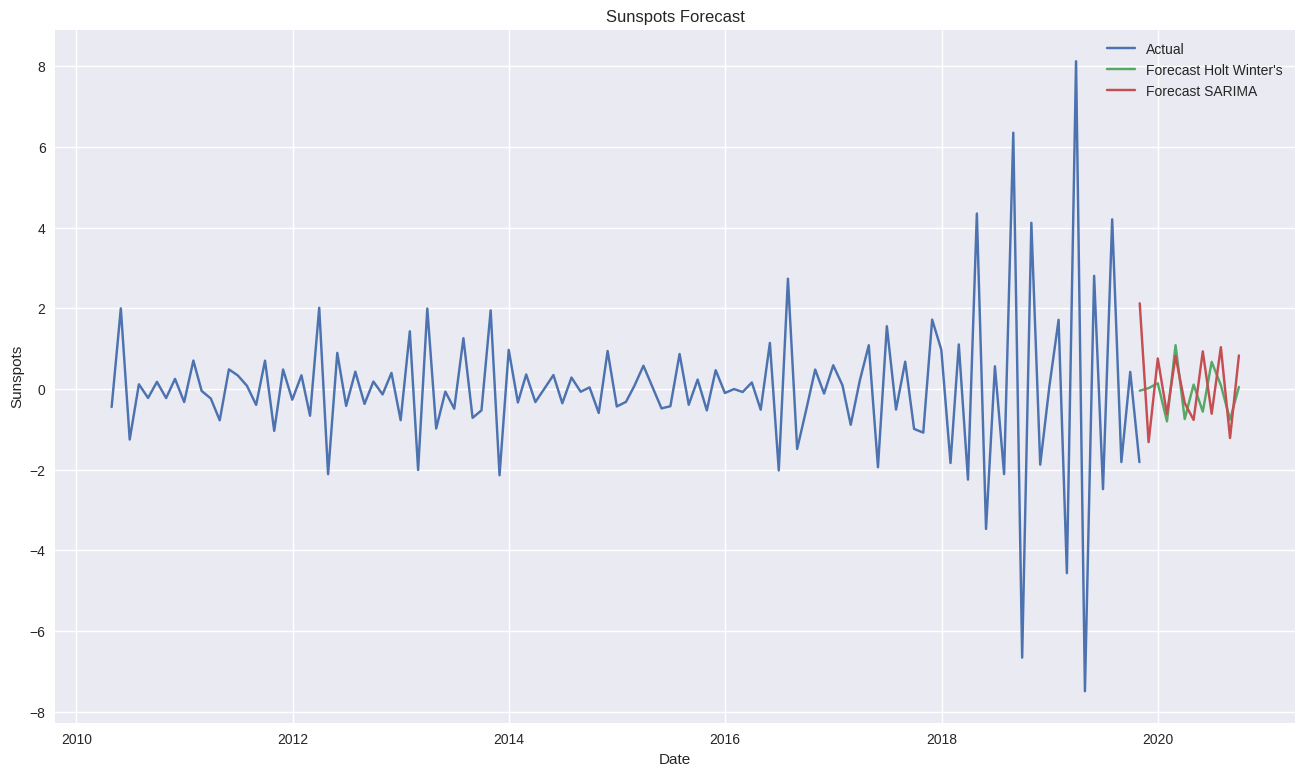

In [59]:
# Plot the actual data
plt.plot(data.index, data.Sunspots, label='Actual')

# Get the forecasted values
forecast_sarima = result_sarima_best_total.forecast(steps=12, index=forecast_index)

# Get the forecasted values
forecast_hw = pd.Series(list(model_HW_full.forecast(steps=12)), index=forecast_index)

# Plot the forecasted values
plt.plot(forecast_hw.index, forecast_hw.values, label='Forecast Holt Winter\'s')

# Plot the forecasted values
plt.plot(forecast_sarima.index, forecast_sarima.values, label='Forecast SARIMA')

# Set the plot title and axis labels
plt.title('Sunspots Forecast')
plt.xlabel('Date')
plt.ylabel('Sunspots')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [60]:
# Get the forecasted values
forecast_hw = pd.Series(list(model_HW_full.forecast(steps=12)), index=forecast_index)
forecast_hw 

2019-11-01   -0.043621
2019-12-01    0.019810
2020-01-01    0.140769
2020-02-01   -0.803904
2020-03-01    1.084429
2020-04-01   -0.746939
2020-05-01    0.107561
2020-06-01   -0.562846
2020-07-01    0.671575
2020-08-01    0.093071
2020-09-01   -0.759717
2020-10-01    0.049426
Freq: MS, dtype: float64

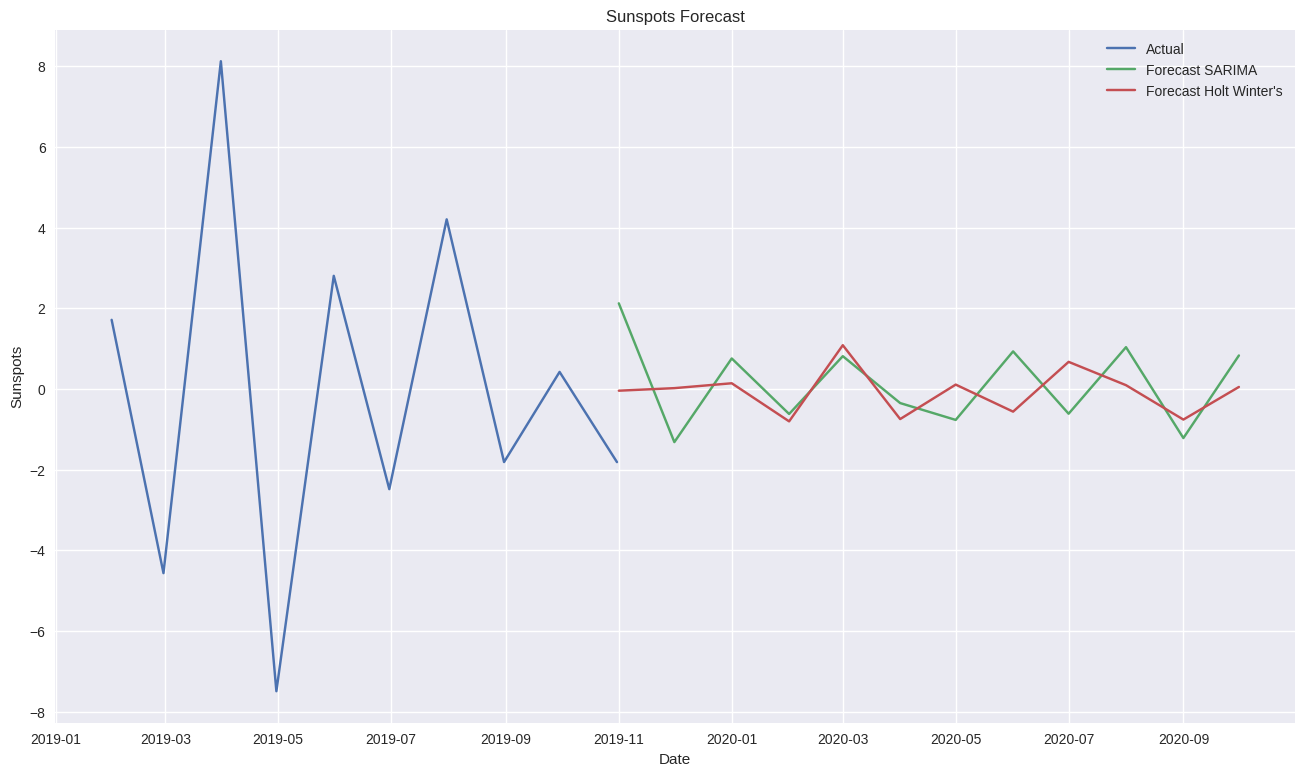

In [61]:
# Plot only the period 2019-2020
plt.plot(data['2019':'2020'].index, data['2019':'2020'].Sunspots, label='Actual')

# Create a date range for the forecast period
forecast_index = pd.date_range(start=data.index[-1], periods=12, freq='MS')

# Get the forecasted values
forecast = result_sarima_best_total.forecast(steps=12, index=forecast_index)

# Plot the forecasted values
plt.plot(forecast.index, forecast.values, label='Forecast SARIMA')

# # Get the forecasted values
forecast_hw = pd.Series(list(model_HW_full.forecast(steps=12)), index=forecast_index)

# # Plot the forecasted values
plt.plot(forecast_hw.index, forecast_hw.values, label='Forecast Holt Winter\'s')


# Set the plot title and axis labels
plt.title('Sunspots Forecast')
plt.xlabel('Date')
plt.ylabel('Sunspots')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### ARCH/GARCH Models

**a. Calculate the return series from the predicted values of the SARIMA model.**

Plot both the original "number of sunspots" series and the calculated return series.
Analyze the stationarity of both series using statistical tests like the Augmented Dickey-Fuller (ADF) test or by visually inspecting the plots.

**b. Perform ACF and PACF diagnostics to identify a good ARMA model for the mean of returns:**

Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for the return series.
Analyze the patterns in the ACF and PACF plots to identify potential ARMA models that capture the autocorrelation structure of the mean of the return series.

**c. Conduct residual diagnostics for the ARMA model, including Ljung-Box statistics:**

Analyze the residuals of the ARMA model by assessing their properties.
Use statistical tests such as the Ljung-Box test to check for the absence of residual autocorrelation.
Comment on the results and evaluate the adequacy of the ARMA model.

**d. Apply Ljung-Box statistics on the squares of residuals to test for serial dependence or heteroskedasticity:**

Square the residuals obtained from the ARMA model.
Utilize the Ljung-Box test on the squared residuals to examine the presence of serial dependence or heteroskedasticity.
Comment on the results and assess the presence of serial dependence or heteroskedasticity.

**e. Plot ACF and PACF for the squares of residuals and identify the dependence order of the GARCH model:**

Calculate the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for the squared residuals.
Analyze the patterns in the ACF and PACF plots to identify the dependence order of the GARCH model, which represents the lag order of the conditional variance.

**f. Construct a loop (or use a built-in function) to find the best GARCH(p, q) model to fit the squared residuals:**

Set a range of values for p and q, such as p < 4 and q < 4.
Use a loop or a built-in function to iterate over the possible combinations of p and q.
Fit GARCH(p, q) models to the squared residuals and evaluate their goodness of fit using appropriate metrics such as Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).

**g. Specify the forecast horizon that is reasonable for your project:**

Determine the forecast horizon that aligns with your project's needs and time frame.

**h. Make a forecast of volatility using the best GARCH(p, q) model with the specified horizon:**

Fit the best GARCH(p, q) model to the entire dataset (including training and validation data).
Generate forecasts of volatility using the fitted GARCH(p, q) model for the specified fo

**a.**

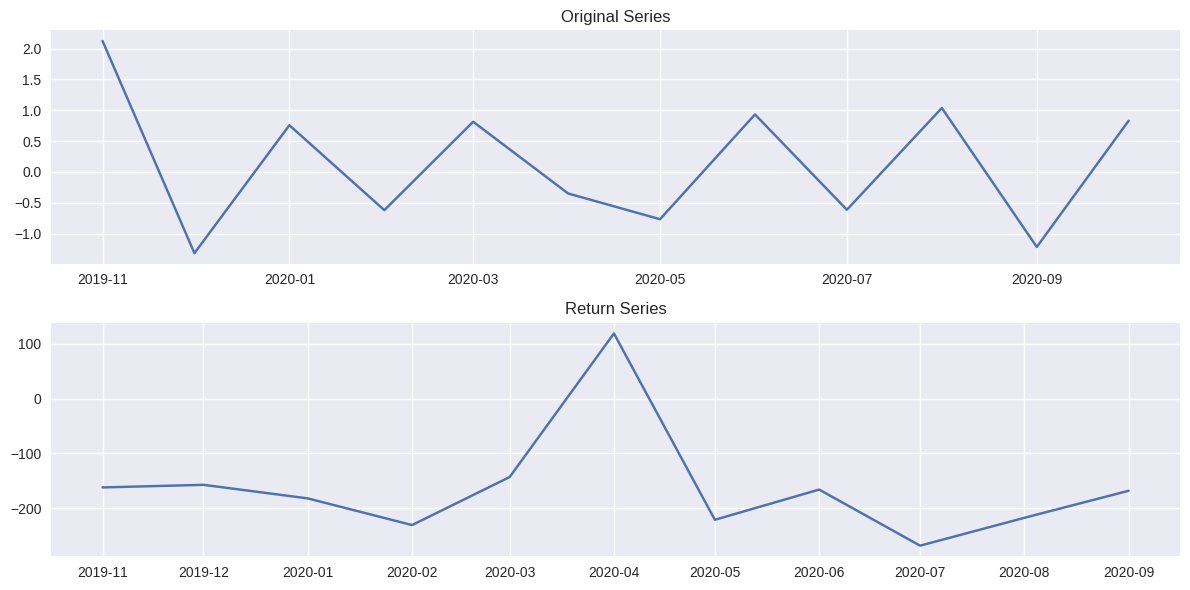

In [62]:
# Calculate return series from predicted values
returns = np.diff(forecast) / forecast[:-1] * 100

# Plot original series and return series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(forecast)
plt.title("Original Series")
plt.subplot(2, 1, 2)
plt.plot(returns)
plt.title("Return Series")
plt.tight_layout()
plt.show()

In [63]:
# Perform ADF test on the original series
adf_result_original = adfuller(forecast)
p_value_original = adf_result_original[1]

# Perform ADF test on the return series
adf_result_returns = adfuller(returns)
p_value_returns = adf_result_returns[1]

print("ADF p-value (Forecast Series):", p_value_original)
print("ADF p-value (Return Series):", p_value_returns)

ADF p-value (Forecast Series): 0.018331895686919602
ADF p-value (Return Series): 0.03949480060548686


* Based on the ADF test results, the p-value for the original series is 0.0183, and the p-value for the return series is 0.0395. For the original series, since the p-value (0.0183) is below the significance level of 0.05, we can reject the null hypothesis of non-stationarity and conclude that the original series is stationary.

* For the return series, the p-value (0.0395) is also below the significance level of 0.05, indicating that we can reject the null hypothesis and conclude that the return series is stationary as well. Both the original series and the calculated return series exhibit stationarity based on the ADF test results. This suggests that they do not have any apparent trends or non-stationary patterns and can be considered as stationary time series.

**b.**

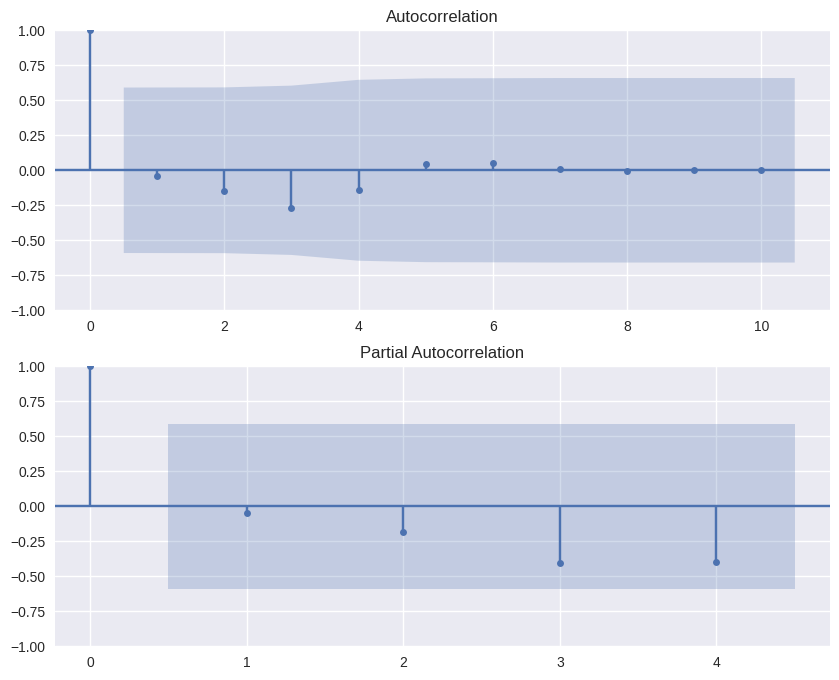

In [64]:
# Plot ACF and PACF for the return series
fig, ax = plt.subplots(2, figsize=(10, 8))
sm.graphics.tsa.plot_acf(returns, lags=10, ax=ax[0])
sm.graphics.tsa.plot_pacf(returns, lags=4, ax=ax[1])
plt.show()

All lags in both the ACF and PACF plots are insignificant, it suggests that there is no significant autocorrelation in the return series. Indicating that the series is already stationary or that the autocorrelation structure is not well captured by an ARMA model.

When all lags are insignificant, it is worth considering simpler models such as an ARMA(0,0) model (i.e., a white noise process) or exploring other time series models that may better capture the behavior of the data. 

**c.**

In [65]:
# Fit the ARMA(0,0) model
model = ARIMA(returns, order=(0, 0, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         predicted_mean   No. Observations:                   11
Model:                          ARIMA   Log Likelihood                 -65.878
Date:                Sat, 20 May 2023   AIC                            135.757
Time:                        16:13:25   BIC                            136.553
Sample:                    11-01-2019   HQIC                           135.255
                         - 09-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -163.4431     58.487     -2.794      0.005    -278.076     -48.810
sigma2      9322.0358   4672.603      1.995      0.046     163.902    1.85e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                14.83
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.84   Skew:                             2.10
Prob(H) (two-sided):                  0.34   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* **Ljung-Box (Q) and Jarque-Bera (JB) tests:** These are statistical tests for residual autocorrelation and normality of residuals, respectively. A low p-value for the JB test suggests a departure from normality. The Q statistic is 0.03 with a high p-value (0.87), indicating no significant autocorrelation in the residuals.

* **Heteroskedasticity (H) and Skew:** Heteroskedasticity measures the variability of residuals. A value of 2.84 suggests moderate heteroskedasticity. The skewness is 2.10, indicating a substantial skew in the residuals.

* **Kurtosis:** Kurtosis measures the heaviness of tails in the distribution. A value of 6.84 suggests relatively heavy tails.

Overall, the model shows a reasonable fit, but there may be some departures from normality and heteroskedasticity in the residuals. The autocorrelation test does not indicate significant autocorrelation in the residuals. It's important to further analyze the residuals to assess the adequacy of the model.

In [66]:
# Calculate the residuals
residuals = model_fit.resid

# check for autocorrelation in the residuals using the Ljung-Box test
lbtest = acorr_ljungbox(residuals, lags=10)

print('Ljung-Box Test Results:')
print(lbtest)

Ljung-Box Test Results:
     lb_stat  lb_pvalue
1   0.026775   0.870021
2   0.369830   0.831175
3   1.697688   0.637448
4   2.087316   0.719703
5   2.137854   0.829760
6   2.217895   0.898608
7   2.219494   0.946700
8   2.220156   0.973508
9   2.220225   0.987487
10  2.220226   0.994357


Based on these results, there is no significant autocorrelation detected in the residuals of the ARIMA model. This suggests that the ARIMA(0,0,0) model adequately captures the autocorrelation structure in the data, as there is no significant evidence of residual autocorrelation at different lags.

Mean of the residuals: 4.902767149029717e-06


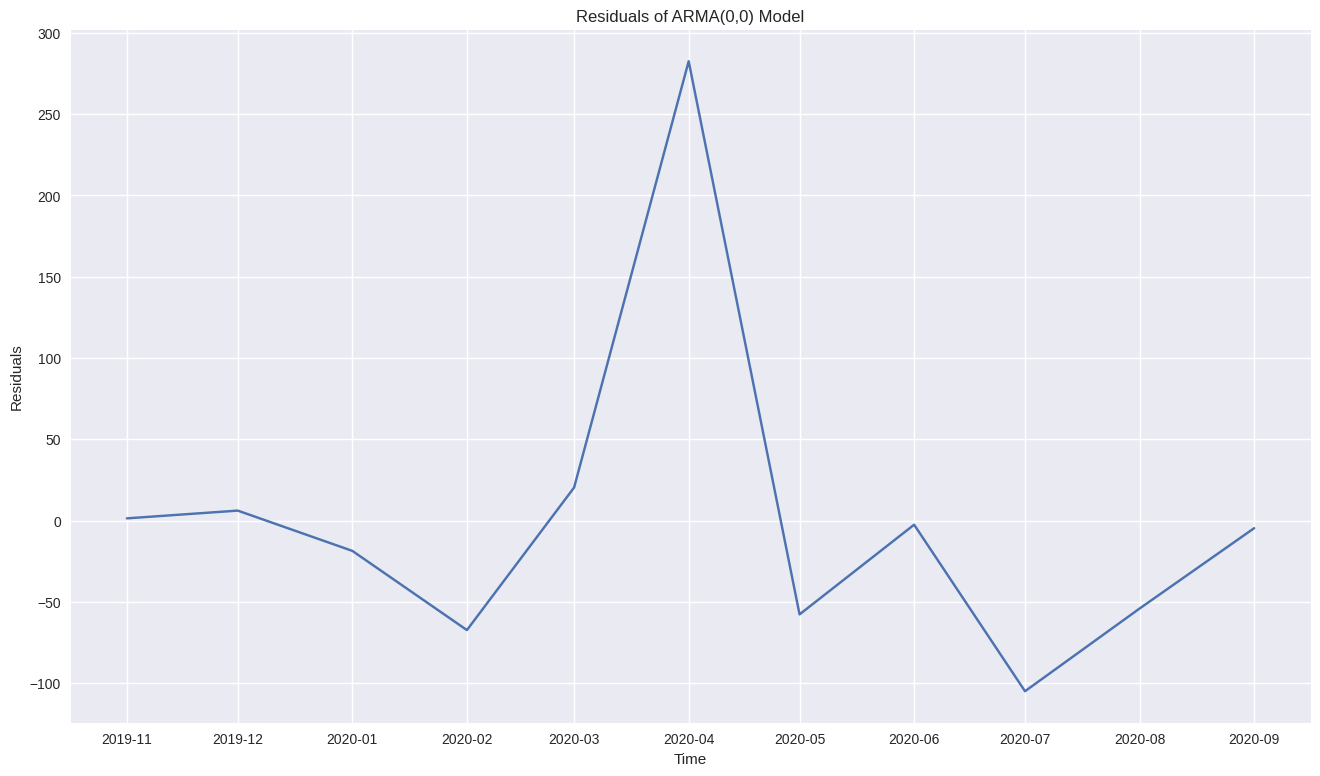

In [67]:
# Check the mean of the residuals
residuals_mean = np.mean(residuals)
print("Mean of the residuals:", residuals_mean)

# Plot the residuals over time
plt.plot(residuals)
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Residuals of ARMA(0,0) Model")
plt.show()

**d.**

In [68]:
# Square the residuals
squared_residuals = residuals**2

# Perform Ljung-Box test on squared residuals
lb_test = sm.stats.acorr_ljungbox(squared_residuals, lags=[10])

# Extract test statistics and p-values
lb_statistic = lb_test.iloc[0, 0]
lb_pvalue = lb_test.iloc[0, 1]

# Print the test results
print("Ljung-Box Test (Squared Residuals):")
print(f"Test Statistic: {lb_statistic}")
print(f"P-value: {lb_pvalue}")

Ljung-Box Test (Squared Residuals):
Test Statistic: 2.1659729987859193
P-value: 0.994902504299418


The Ljung-Box test applied to the squared residuals yields a test statistic of 2.1659 and a p-value of 0.9949.

The p-value is greater than the commonly used significance level of 0.05, indicating that there is no significant evidence to reject the null hypothesis of no serial dependence or heteroskedasticity in the squared residuals. This suggests that the squared residuals do not exhibit significant autocorrelation or heteroskedasticity.

Based on these results, we can conclude that there is no evidence of serial dependence or heteroskedasticity in the squared residuals, indicating that the ARMA model adequately captures the patterns and variability in the data.

**e.**

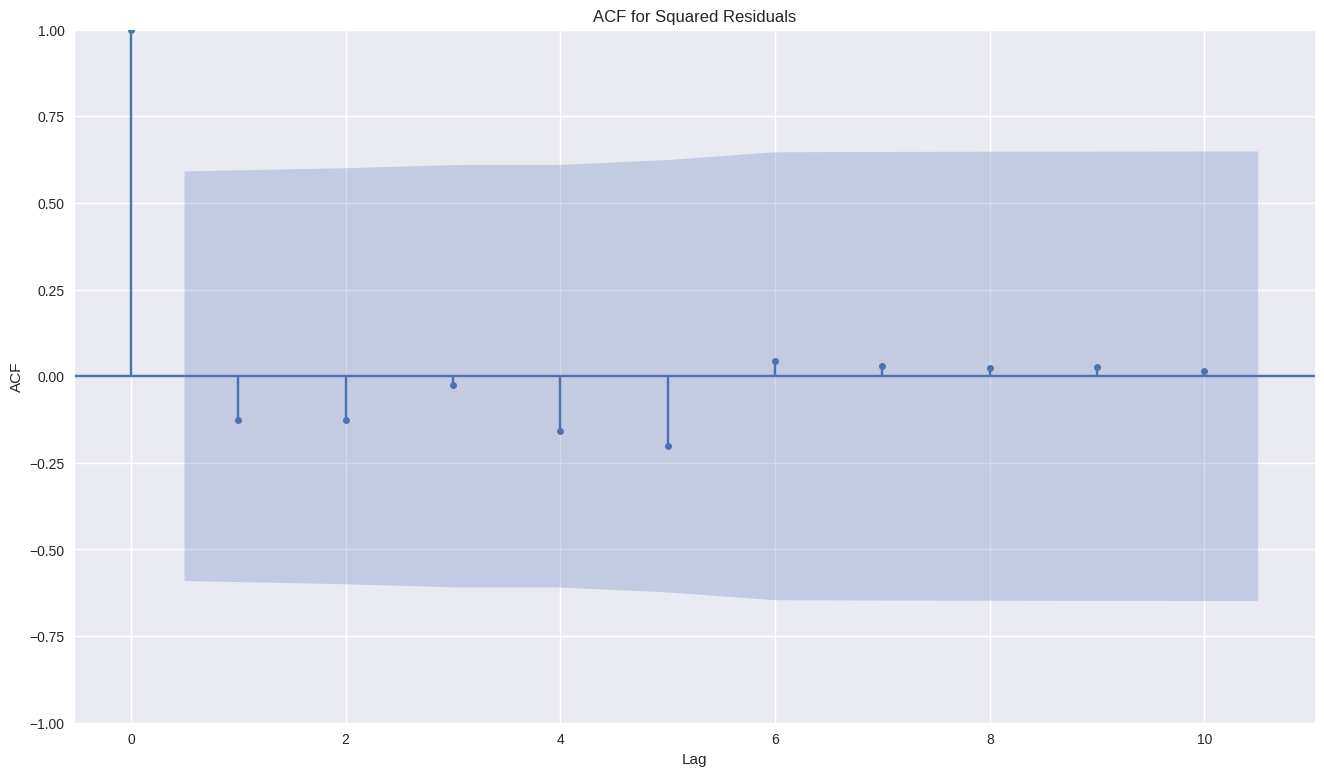

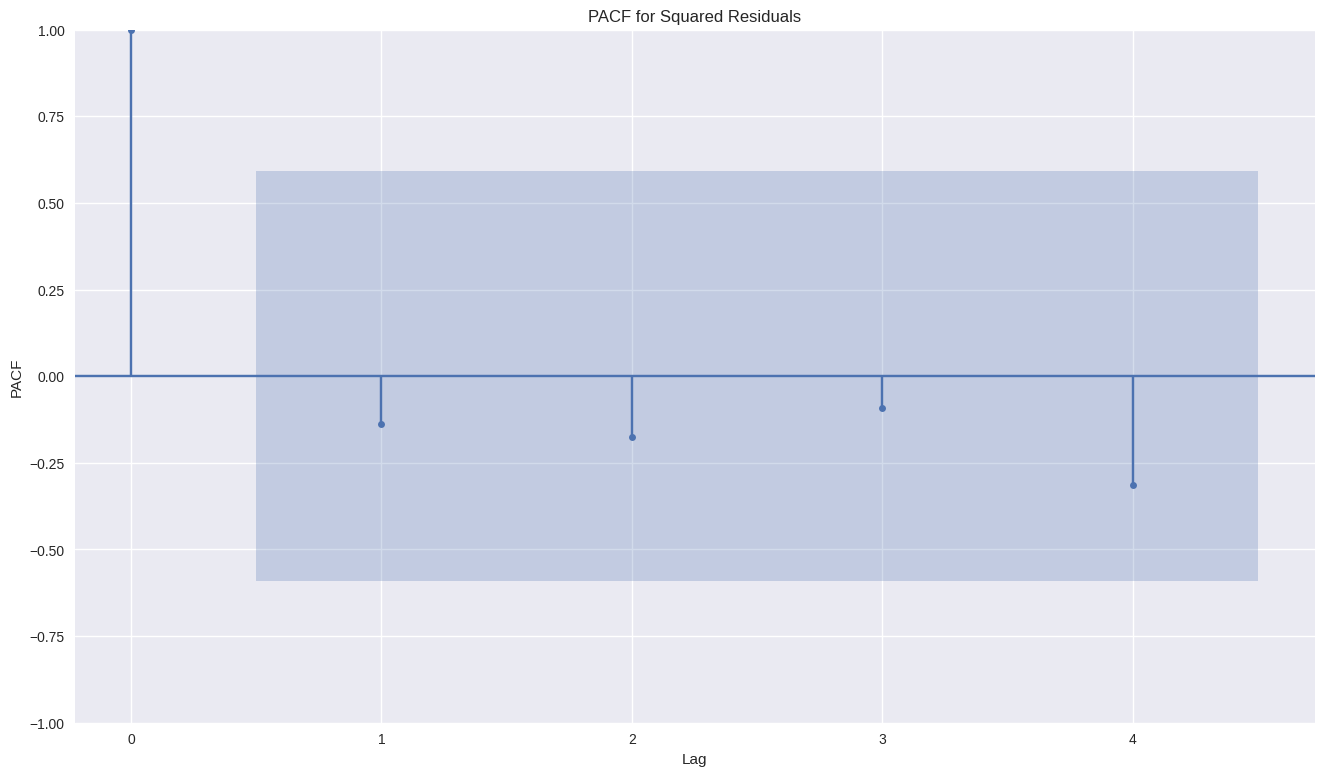

In [69]:
# Plot ACF for squared residuals
sm.graphics.tsa.plot_acf(squared_residuals, lags=10)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('ACF for Squared Residuals')
plt.show()

# Plot PACF for squared residuals
sm.graphics.tsa.plot_pacf(squared_residuals, lags=4)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('PACF for Squared Residuals')
plt.show()

All lags in both the ACF and PACF plots for the squared residuals are non-significant, it suggests that there is no significant autocorrelation or partial autocorrelation present in the squared residuals.

In this case, it indicates that the squared residuals are likely independent and do not exhibit any systematic patterns or dependence over time. This is favorable for modeling with a GARCH model, as it assumes that the conditional variance is driven by past squared residuals without any additional autocorrelation.

Therefore, when all lags in the ACF and PACF plots of squared residuals are non-significant, it suggests that a GARCH(0,0) model, also known as the constant conditional variance model, may be appropriate. This model assumes that the conditional variance is constant over time and not influenced by past squared residuals or autocorrelation. However, the GARCH(0,0) model is not a valid specification since it assumes no autoregressive or moving average terms in the conditional variance equation, which means there is no persistence or volatility clustering in the data. So, we can go with a **GARCH(1,1)** model.

**f.**

In [70]:
# Define the range of values for p and q
p_values = range(1, 4)
q_values = range(1, 4)

best_aic = float('inf')
best_model = None

# Iterate over the possible combinations of p and q
for p in p_values:
    for q in q_values:
        # Fit GARCH(p, q) model to the squared residuals
        model = arch.arch_model(squared_residuals, vol='Garch', p=p, q=q)
        model_fit = model.fit(disp='off')
        
        # Evaluate the model based on AIC
        aic = model_fit.aic
        print(f"GARCH({p}, {q}) model - AIC: {aic}")
        
        if aic < best_aic:
            best_aic = aic
            best_model = model_fit
            best_p = p
            best_q = q

# Print the best model and its AIC
print("Best GARCH(p, q) model:")
print("p =", best_p)
print("q =", best_q)
print("AIC =", best_aic)


GARCH(1, 1) model - AIC: 259.678819459293
GARCH(1, 2) model - AIC: 261.677953081612
GARCH(1, 3) model - AIC: 263.67795263134855
GARCH(2, 1) model - AIC: 261.67882320950133
GARCH(2, 2) model - AIC: 263.67795216250215
GARCH(2, 3) model - AIC: 265.6779523403284
GARCH(3, 1) model - AIC: 263.6788219359373
GARCH(3, 2) model - AIC: 265.67795216629224
GARCH(3, 3) model - AIC: 267.6779523682102
Best GARCH(p, q) model:
p = 1
q = 1
AIC = 259.678819459293


**g., h.**

In [71]:
# Specify the forecast horizon
forecast_horizon = 12

# Fit GARCH(1,1) model to the squared residuals
garch_model = arch.arch_model(squared_residuals, vol='Garch', p=1, q=1)
garch_model_fit = garch_model.fit(disp='off')

# Generate forecasts
garch_forecasts = garch_model_fit.forecast(start=0, horizon=forecast_horizon)

# Access the forecasted conditional variances
forecasted_variances = garch_forecasts.variance.values[-1, :]

# Print the forecasted variances
print("Forecasted Variances:")
print(forecasted_variances)

Forecasted Variances:
[5.49284693e+08 5.49297744e+08 5.49304765e+08 5.49308542e+08
 5.49310573e+08 5.49311666e+08 5.49312254e+08 5.49312570e+08
 5.49312740e+08 5.49312832e+08 5.49312881e+08 5.49312908e+08]


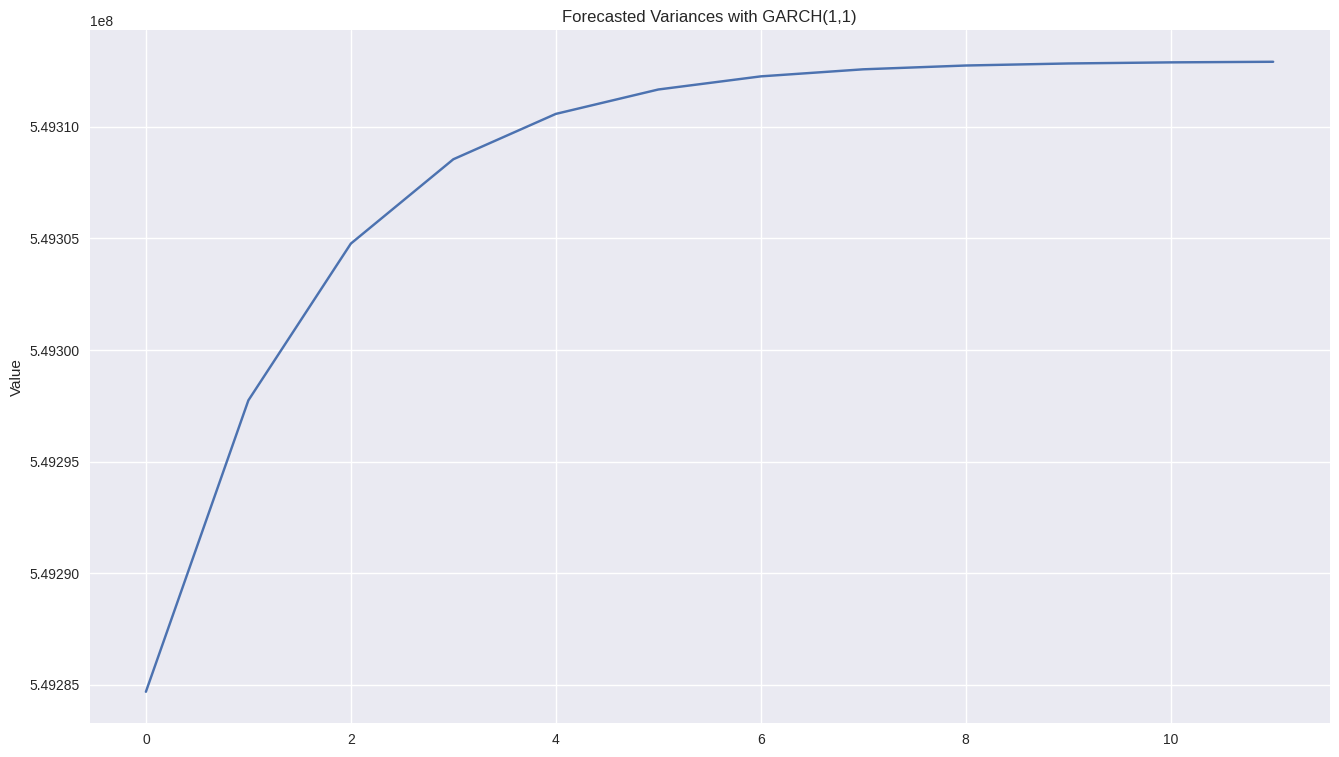

In [79]:
# Plot the residuals over time
plt.plot(forecasted_variances)
plt.ylabel("Value")
plt.title("Forecasted Variances with GARCH(1,1)")
plt.show()

**Return Series:** By defining a return series from the predicted values of the SARIMA model, we transformed the sunspot data into a format that captures the changes or deviations from the expected values. This allows us to analyze and model the mean of the returns, which can provide additional insights into the underlying dynamics of the data.

**ARMA Model:** By identifying a good ARMA model for the mean of the returns, we have effectively captured the autocorrelation structure of the data. This model helps us to understand and explain the relationship between past and current values in the mean of the returns, which is crucial for making accurate predictions and understanding the underlying behavior of the data.

**GARCH Model:** By identifying the dependence order of the GARCH model for the squares of residuals, we have captured the volatility or variance dynamics in the data. This model helps us to model and forecast the volatility, which is important for understanding the level of uncertainty or risk associated with the sunspot data. The GARCH model allows us to capture time-varying volatility patterns, which can be useful for risk management, option pricing, and portfolio optimization.

**Forecasting Volatility:** By making a forecast of volatility using the GARCH(1, 1) model with a specified horizon of 12, we can project the future volatility levels in the sunspot data. This information is valuable for decision-making processes that involve risk management, asset allocation, or trading strategies. It helps stakeholders assess and prepare for potential fluctuations or changes in the level of volatility.

Overall, the analysis you have conducted contributes to a deeper understanding of the sunspot data, its underlying dynamics, and the associated risks. It enables better decision-making and planning, especially in fields that are sensitive to sunspot activity and its impacts.